# Mustererkennung – Aufgabenblatt 5

Bei Fragen: [florian.hartmann@fu-berlin.de](mailto:florian.hartmann@fu-berlin.de?subject=[Mustererkennung]) – E-Mail-Titel der mit [ME] oder [Mustererkennung] anfängt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Daten laden und visualisieren

In [3]:
X = pd.read_csv("data/2d/2d-em.csv", header=None).as_matrix()

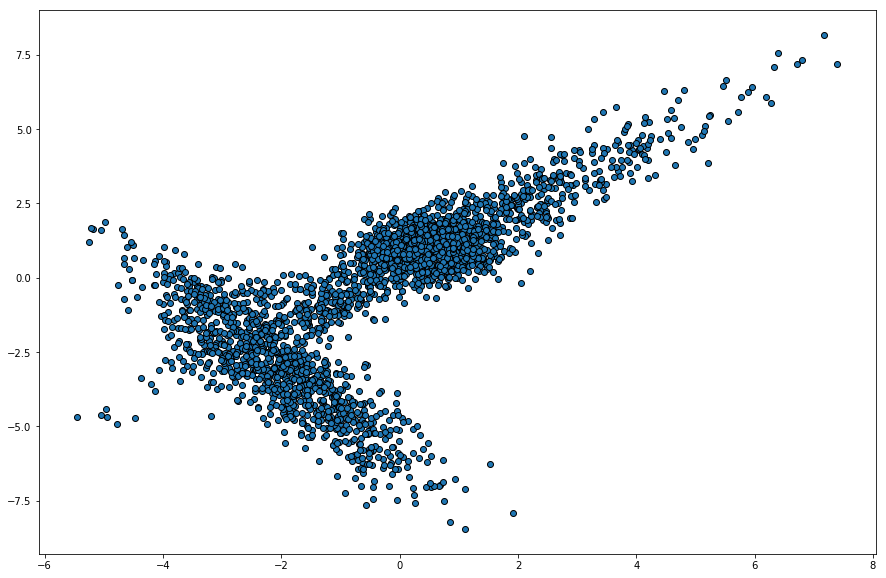

In [4]:
x, y = zip(*X)
plt.figure(figsize=(15, 10))
plt.scatter(x, y, edgecolors="black")

## Generelle Hilfsfunktionen

In [5]:
from numpy.linalg import pinv, cond

In [6]:
def noop(*_): pass

### Multivariate Normalverteilungen

In [7]:
def mean(X):
    if len(X) == 0:
        return 0
    else:
        return np.mean(X, axis=0)

In [8]:
def covariance_matrix(X, mu):
    num_samples, _ = X.shape
    X_normalized = X - mu
    return X_normalized.T.dot(X_normalized) / num_samples

### Lineare Algebra

In [9]:
def is_matrix_invertible(matrix):
    return cond(matrix) < 1 / np.spacing(1)

In [10]:
def make_invertible(matrix):
    if is_matrix_invertible(matrix):
        return matrix
    else:
        return make_invertible(matrix + 1e-5 * np.eye(matrix.shape[0]))

## Clustern

Generelle Beschreibung des Algorithmus:
1. Für eine Anzahl an Clustern und eine maximalen Anzahl an Iterationen entscheiden
2. FürjedenClustereinenzufälligenMittelpunktsvektor(z.B.durchzufälligesZiehenausdem
Trainingsdatensatz) und eine Kovarianzmatrix (z.B. die Identitätsmatrix) generieren
3. Für die Anzahl an Iterationen wiederholen (oder ggf. bis zur Konvergenz):
    - Expectation: Für jeden Datenpunkt in der Trainingsmenge entscheiden und speichern welchem Cluster er am nächsten ist
    - Maximization: Für jedes Cluster alle zugewiesenen Datenpunkte betrachten und mit diesen den neuen Mittelpunktsvektor und die neue Kovarianzmatrix berechnen

Die Distanz eines Datenpunktes zu einem Cluster wird durch die Normalverteilung / Mahalanobisdistanz berechnet. Der K-Means-Algorithmus wie in DBS beschrieben, ist ein Spezialfall von EM bei dem $\Sigma = I$

In [11]:
from random import sample, seed
from numpy import pi, e, sin, cos, sqrt
from numpy.linalg import det, norm
from scipy.stats import multivariate_normal

In [12]:
class ExpectationMaximization:
    def __init__(self, num_clusters, random_state=None):
        self.num_clusters = num_clusters
        
        if random_state is not None:
            seed(random_state)
        
    def fit(self, X, num_iterations=5, callback=noop):
        self._init_parameters(X)
        
        for i in range(num_iterations):
            clusters = self._assign_points_to_cluster(X) # expectation
            callback(clusters, self, i)
            self._recalculate_parameters(clusters)       # maximization
    
    def _init_parameters(self, X):
        _, dim = X.shape
        self.means = sample(X, self.num_clusters)
        self.covariances = [np.eye(dim) for _ in range(self.num_clusters)]
    
    def _assign_points_to_cluster(self, X):
        assignments = self.predict(X)
        return [X[assignments == i] for i in range(self.num_clusters)]
    
    def _recalculate_parameters(self, clusters):
        for i in range(self.num_clusters):
            cluster = clusters[i]
            
            if len(cluster) == 0:
                continue
            
            self.means[i] =  mean(clusters[i])
            self.covariances[i] = make_invertible(covariance_matrix(cluster, self.means[i]))
            
    def predict(self, X):
        probs = []
        
        for mu, sigma in zip(self.means, self.covariances):
            probs.append(self._distance(X, mu, sigma))
            
        return np.vstack(probs).argmin(axis=0)
    
    def _distance(self, X, mu, sigma):
        return 1 - multivariate_normal.pdf(X, mu, sigma)
            
    def evaluate(self):
        return np.mean([norm(cov) for cov in self.covariances])

In [13]:
class KMeans(ExpectationMaximization):
    def _distance(self, X, mu, _):
        return norm(X - mu, axis=1)

## Aufgabe 1: 2D

### Visualisieren

In [14]:
from IPython import display
import time

In [15]:
def get_covariance_ellipse(covariance):
    num_points = 500
    radius = 1

    arcs = np.linspace(0, 2 * pi, num_points)
    X = radius * cos(arcs)
    Y = radius * sin(arcs)
    data = np.array(zip(X, Y))

    X_transformed, Y_transformed = zip(*np.dot(data, covariance))
    return X_transformed, Y_transformed

In [16]:
def parameter_iterator(clusters, model):
    for cluster, mean, covariance in zip(clusters, model.means, model.covariances):
        if len(cluster) != 0:
            yield cluster, mean, covariance

In [17]:
def visualize_clusters(clusters, model, i):
    plt.figure(figsize=(15, 10))

    # Two loops because the order is important for plotting
    for cluster, mean, _ in parameter_iterator(clusters, model):
        x, y = zip(*cluster)
        plt.scatter(x, y)

    for _, mean, covariance in parameter_iterator(clusters, model):
        plt.scatter([mean[0]], [mean[1]], color="black", s=150, marker="x")

        if not isinstance(model, KMeans):
            x, y = get_covariance_ellipse(covariance)
            plt.plot(x + mean[0], y + mean[1], color="black")
        
    return plt.title("%d clusters, iteration #%d" % (model.num_clusters, i + 1))

#### Visualisierung 1: Alle Iterationen plotten

Es gibt zwei Visualisierungen: In einer wird nach jeder Iteration ein Plot erzeugt (gut für PDFs). In der anderen wird das Bild in jeder Iteration aktualisiert (gut für interaktive Visualisierungen).

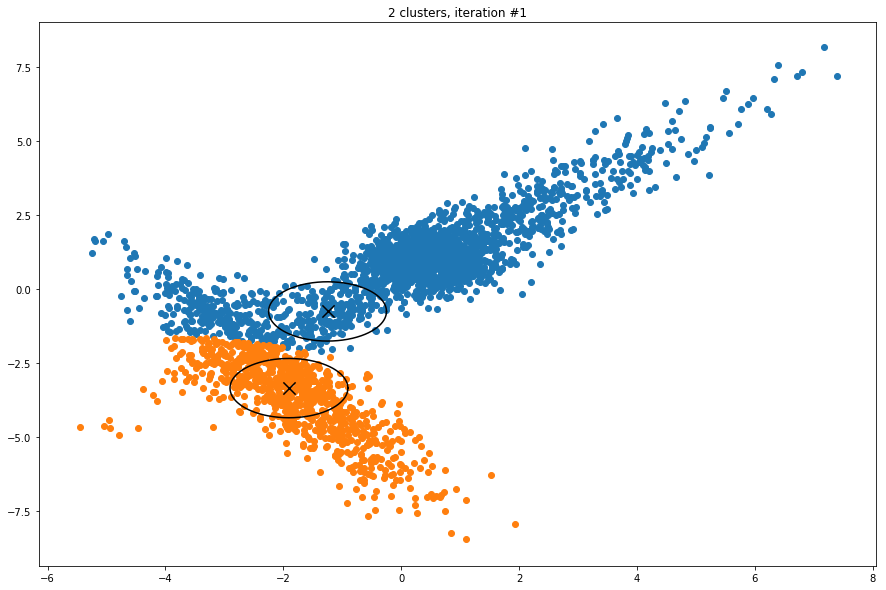

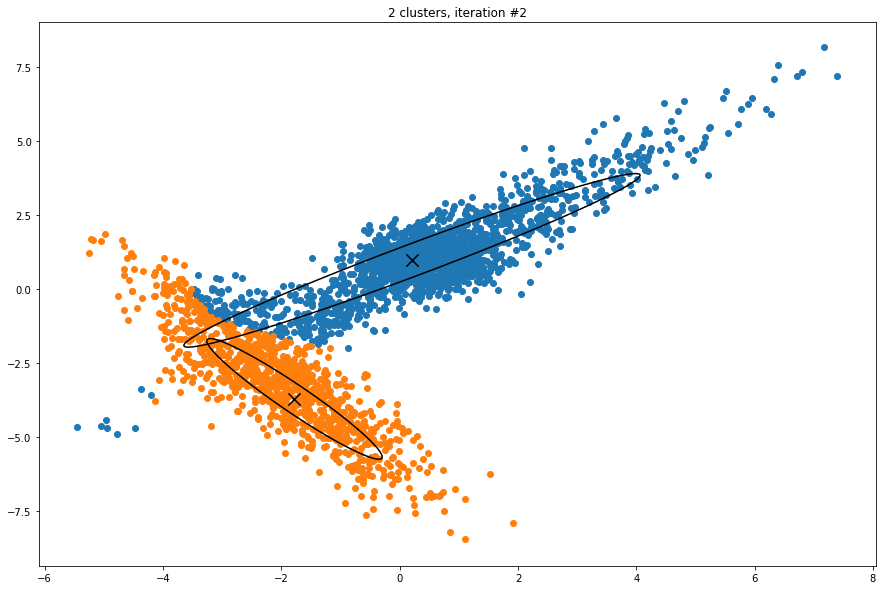

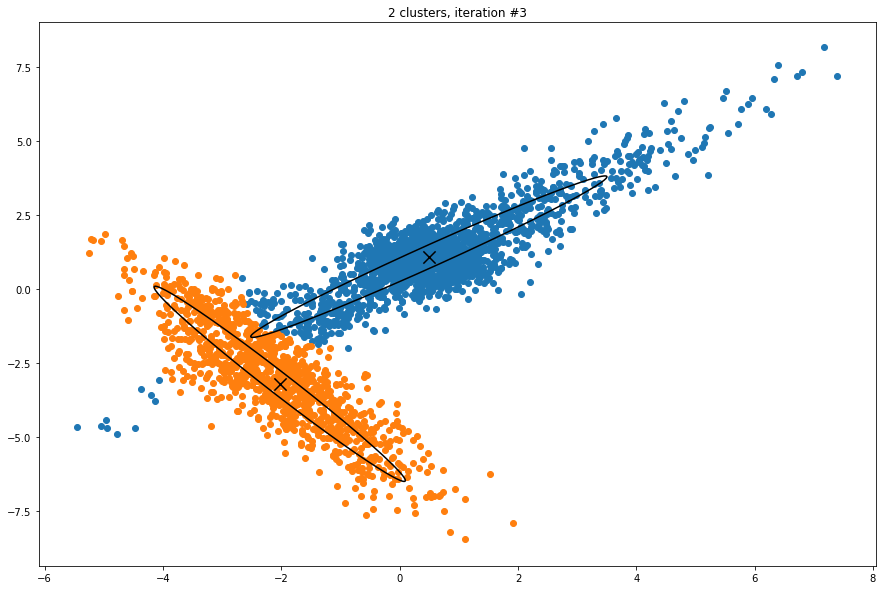

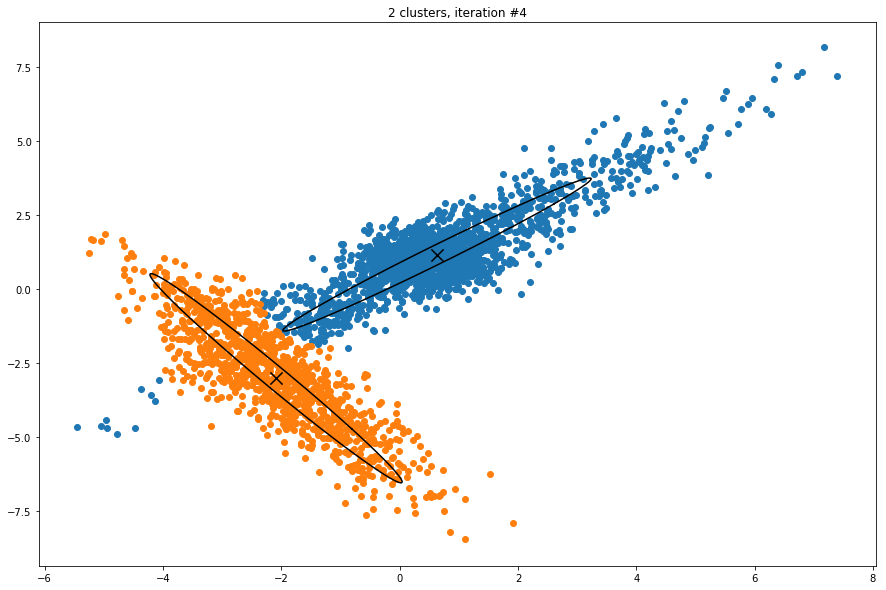

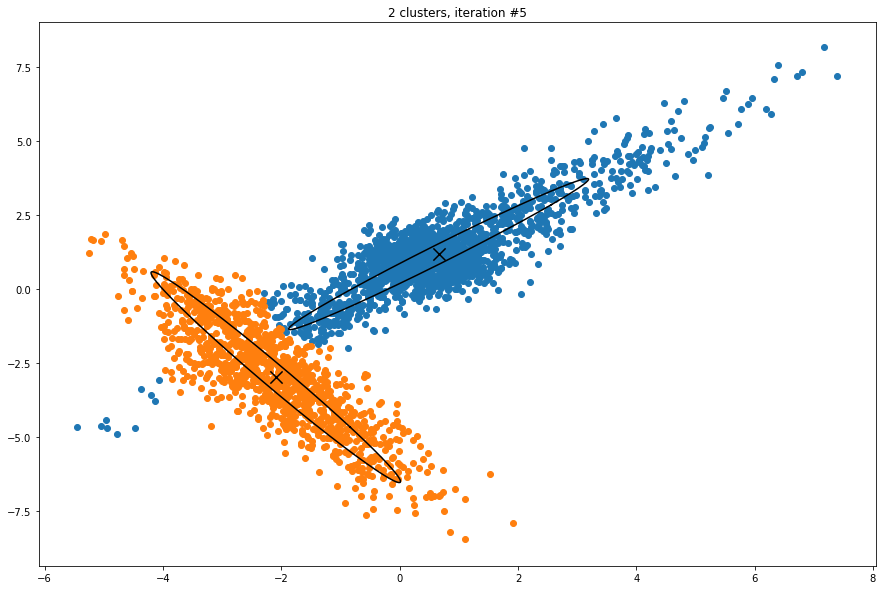

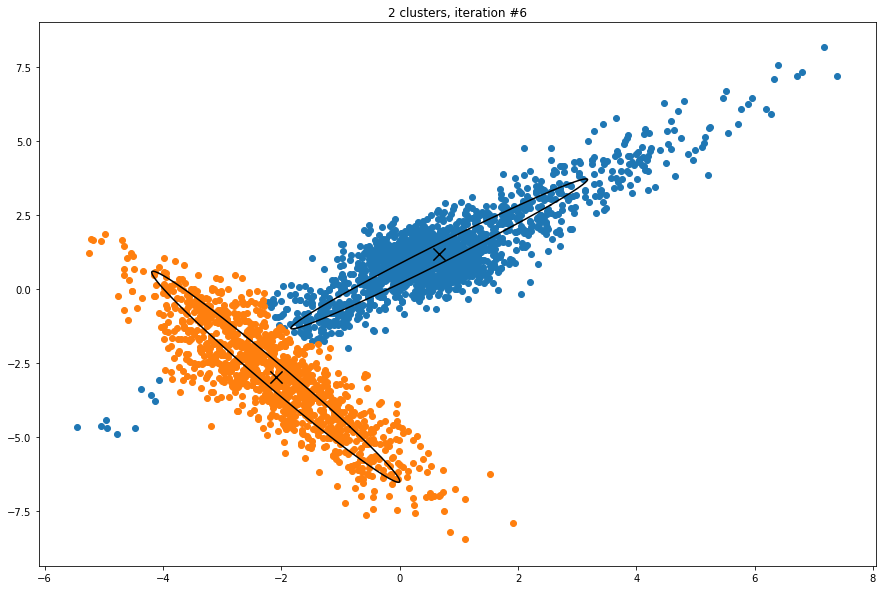

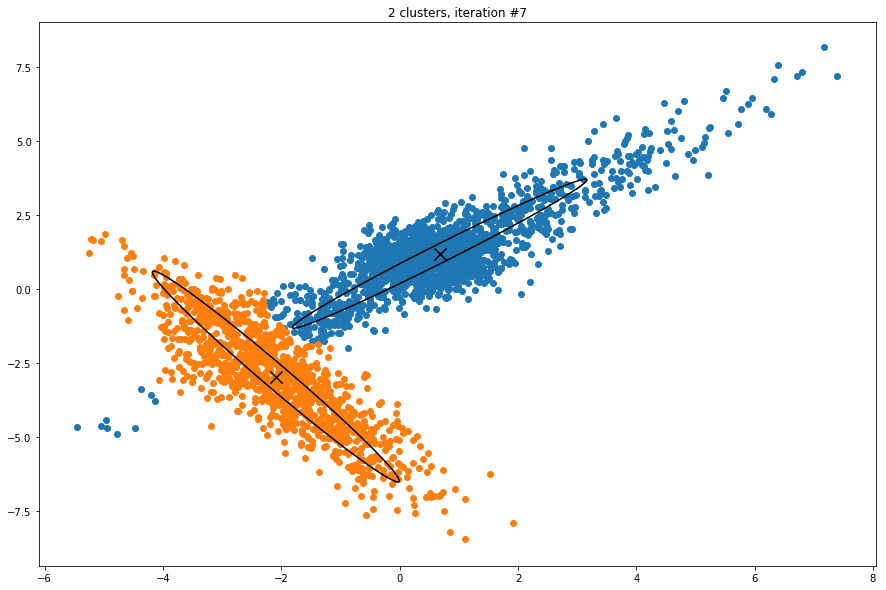

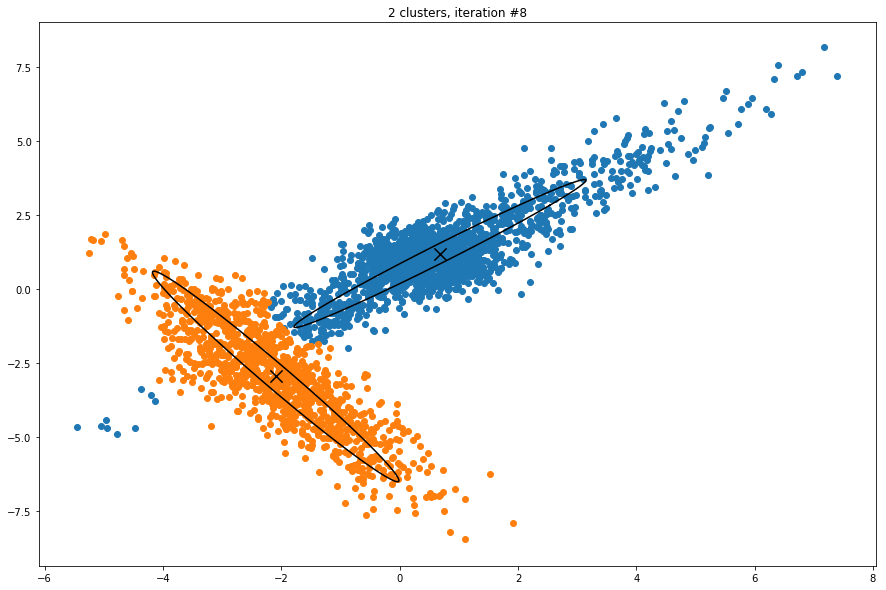

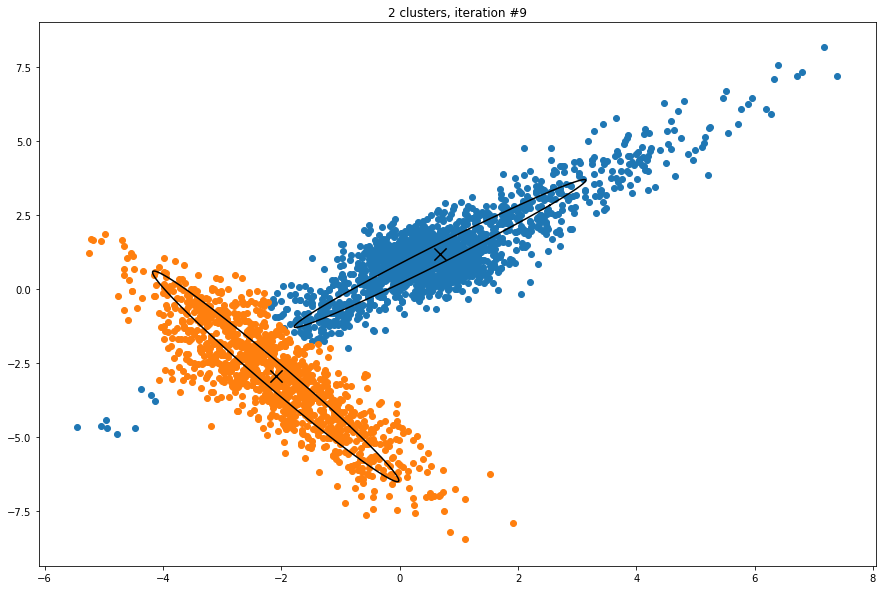

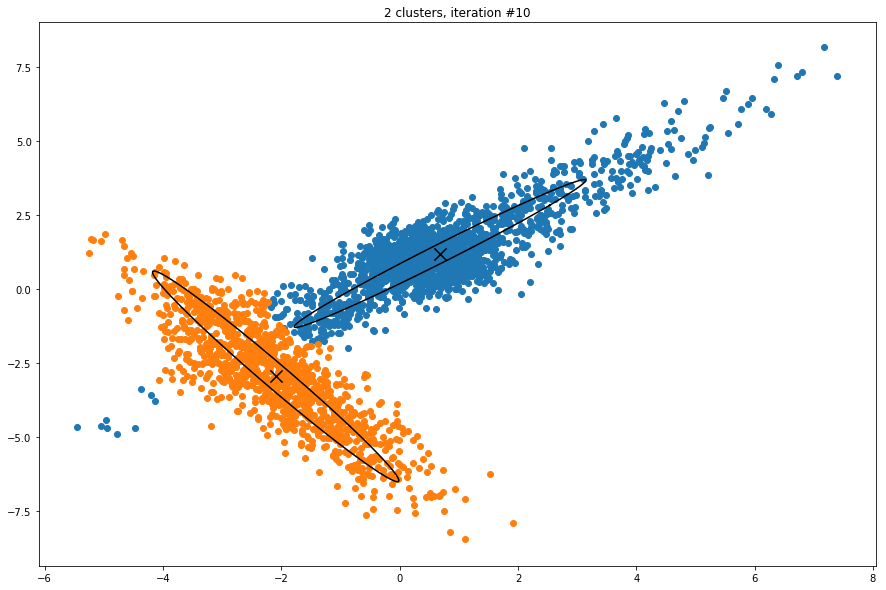

In [17]:
model = ExpectationMaximization(num_clusters=2)
model.fit(X, callback=visualize_clusters, num_iterations=10)

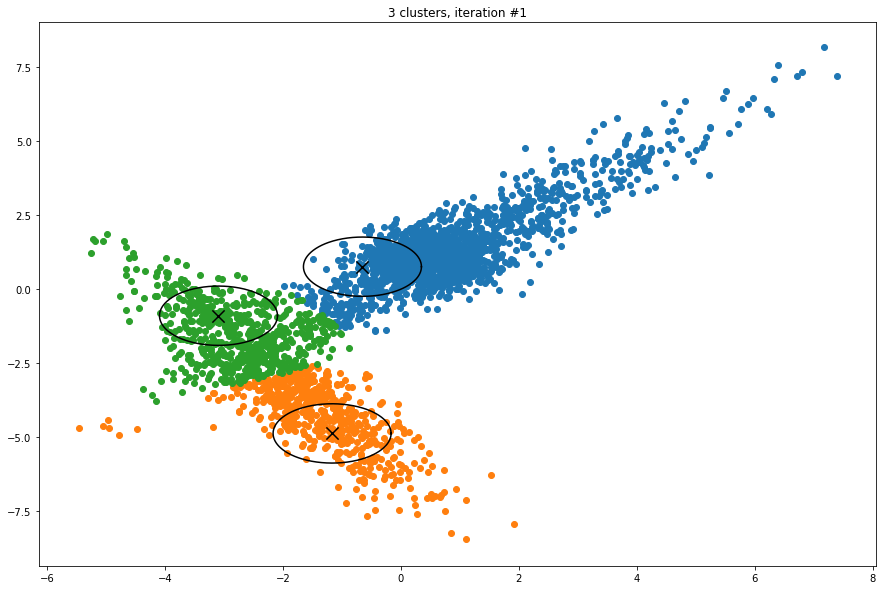

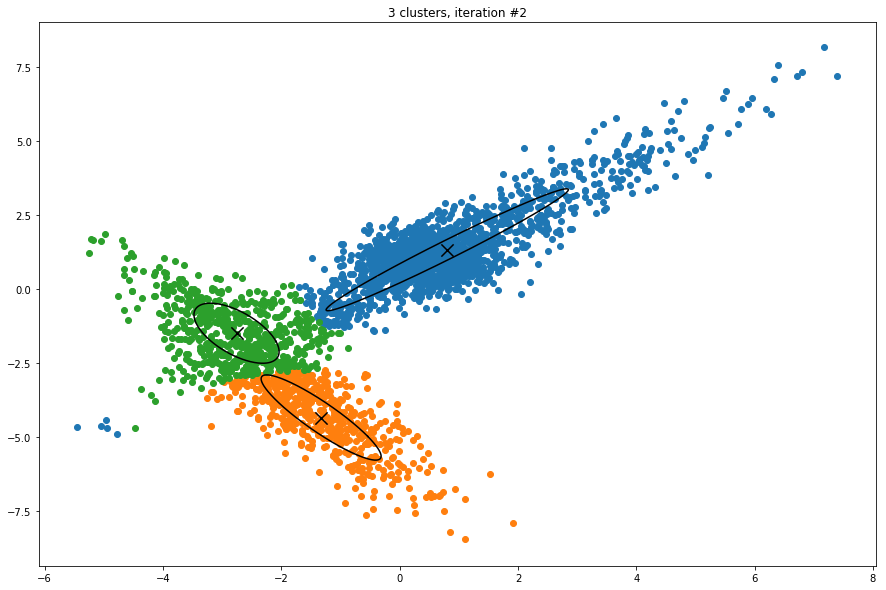

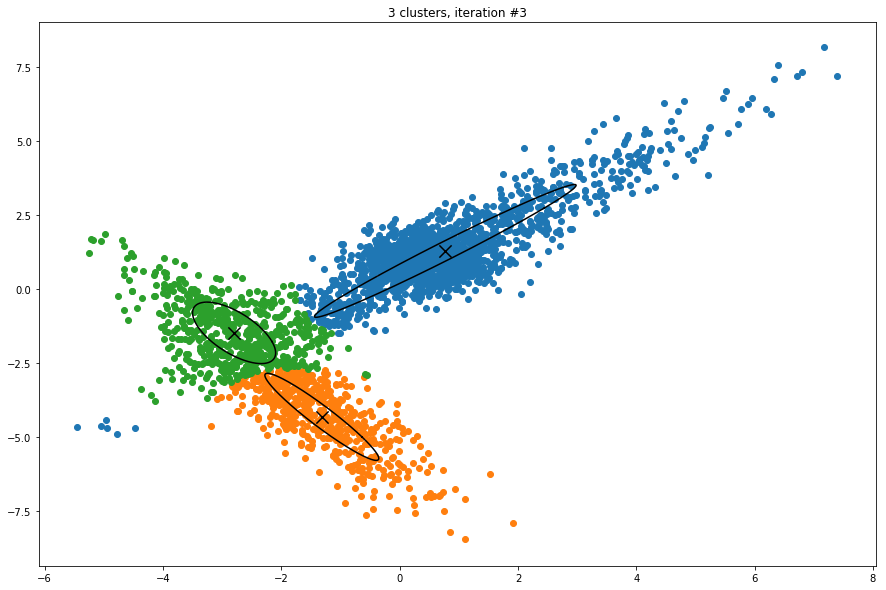

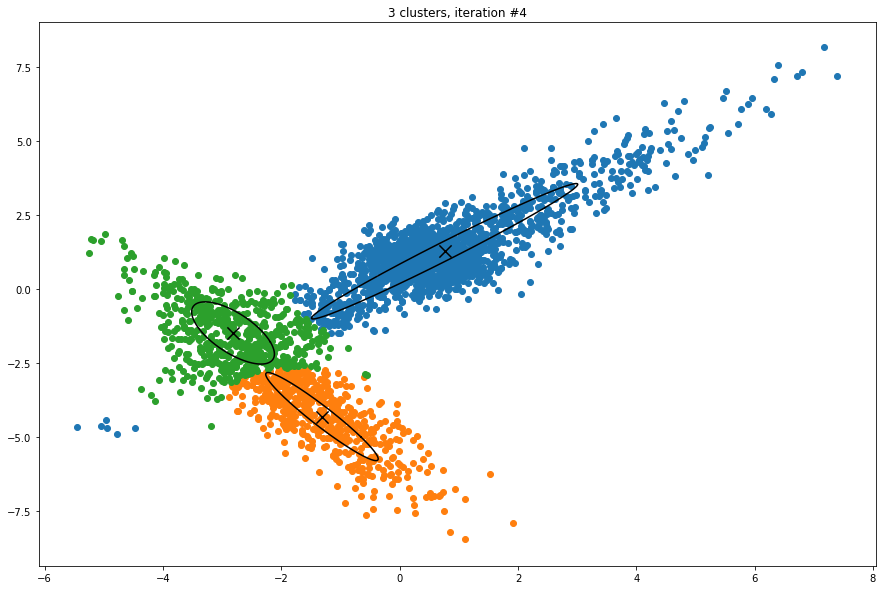

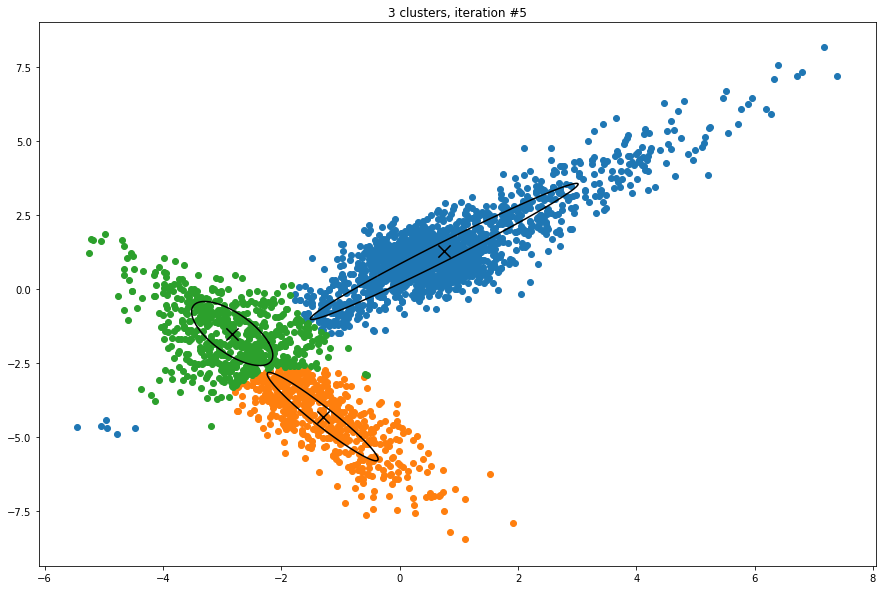

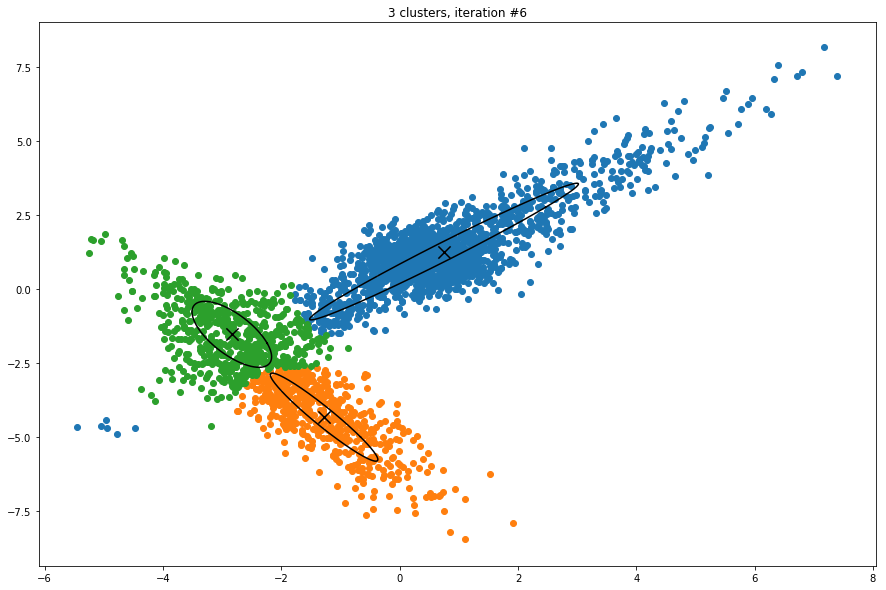

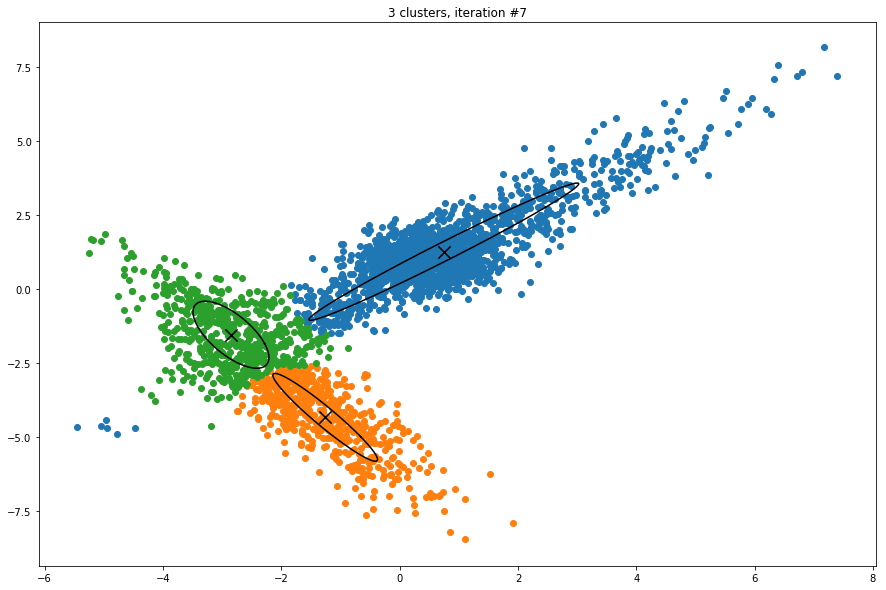

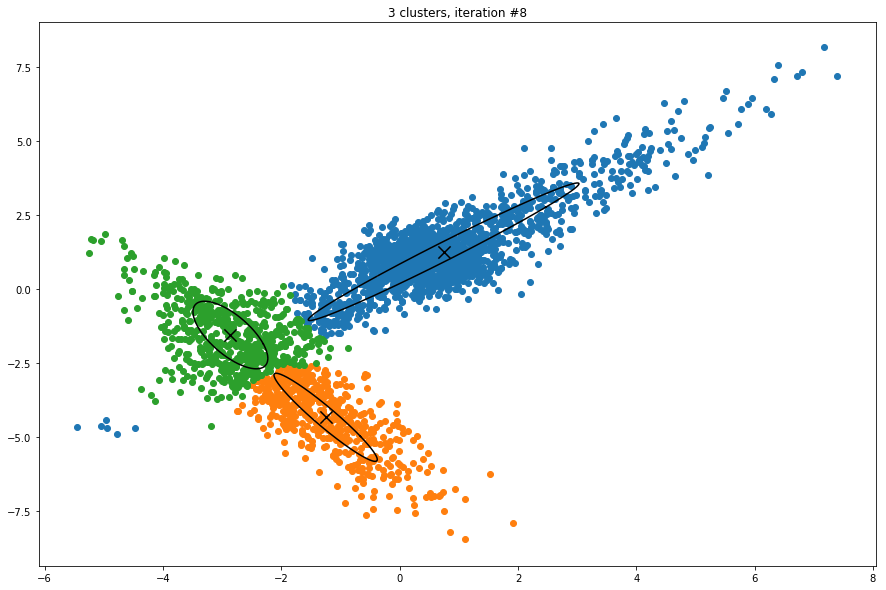

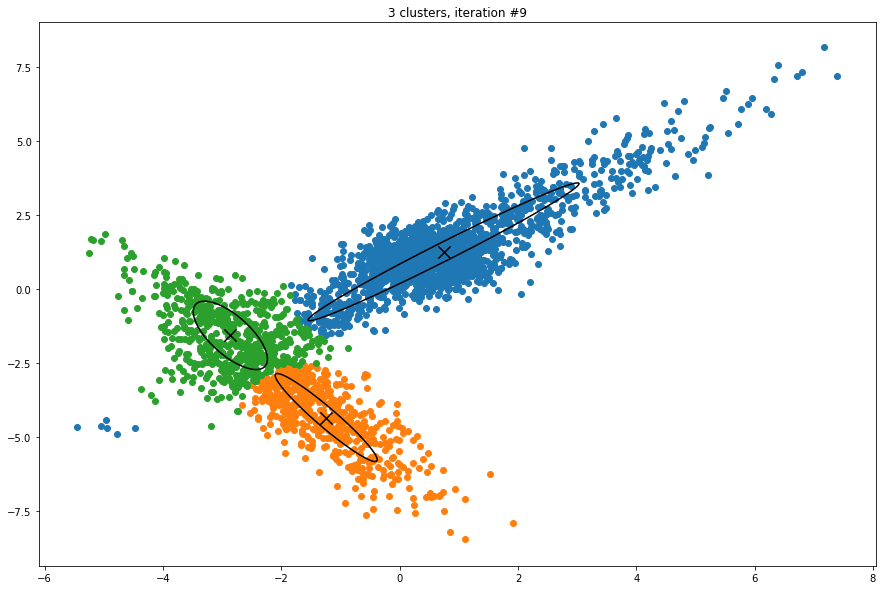

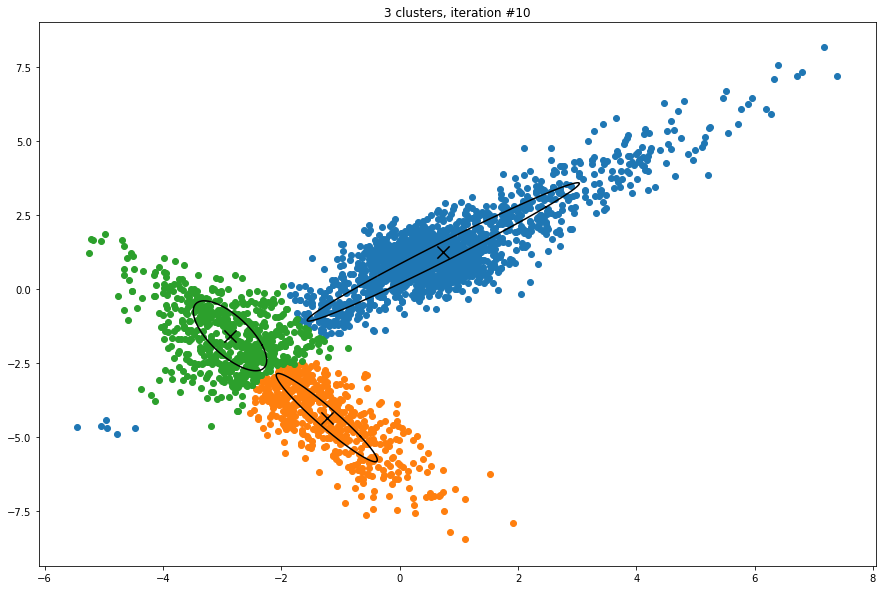

In [18]:
model = ExpectationMaximization(num_clusters=3)
model.fit(X, callback=visualize_clusters, num_iterations=10)

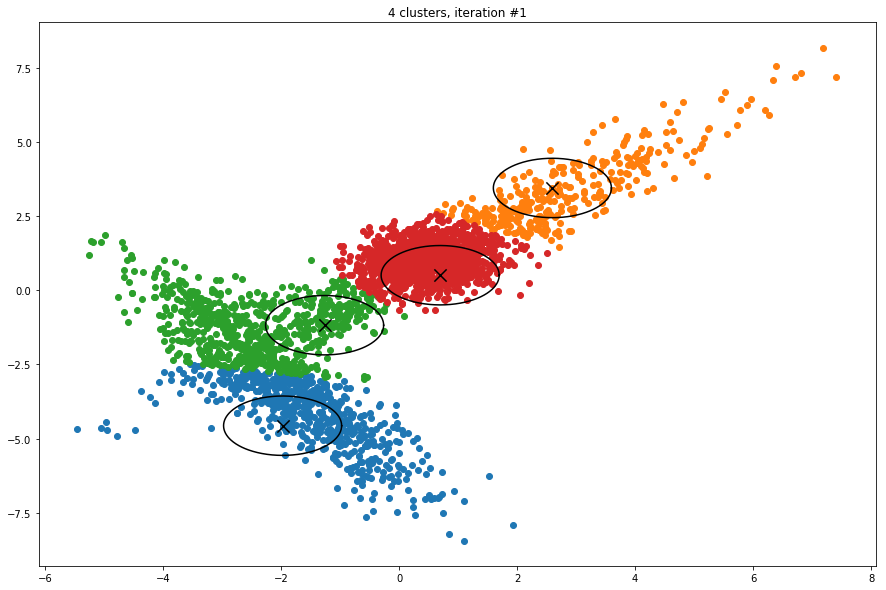

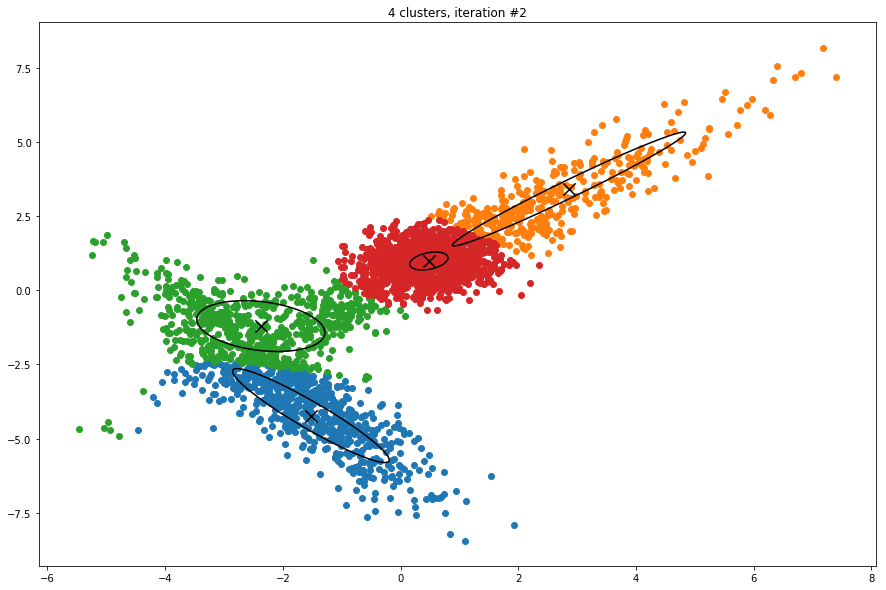

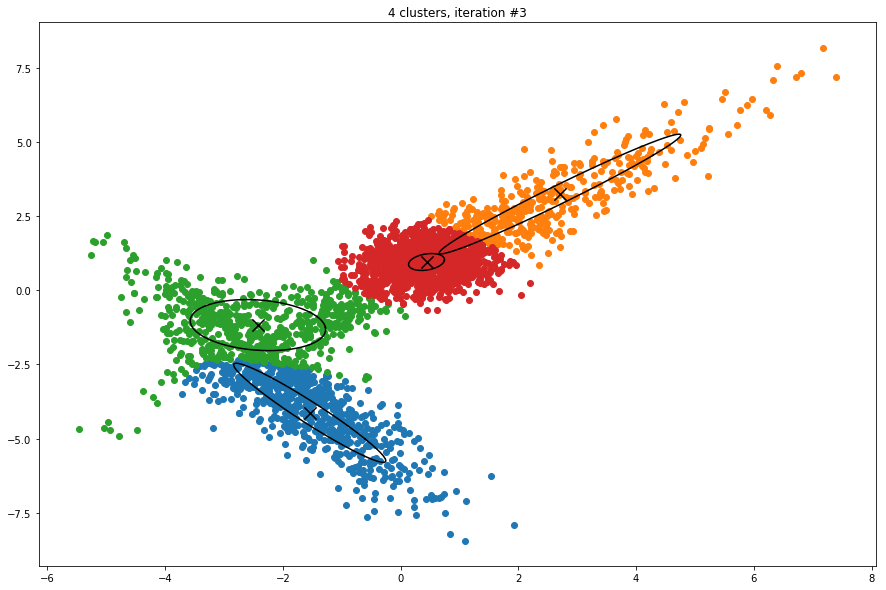

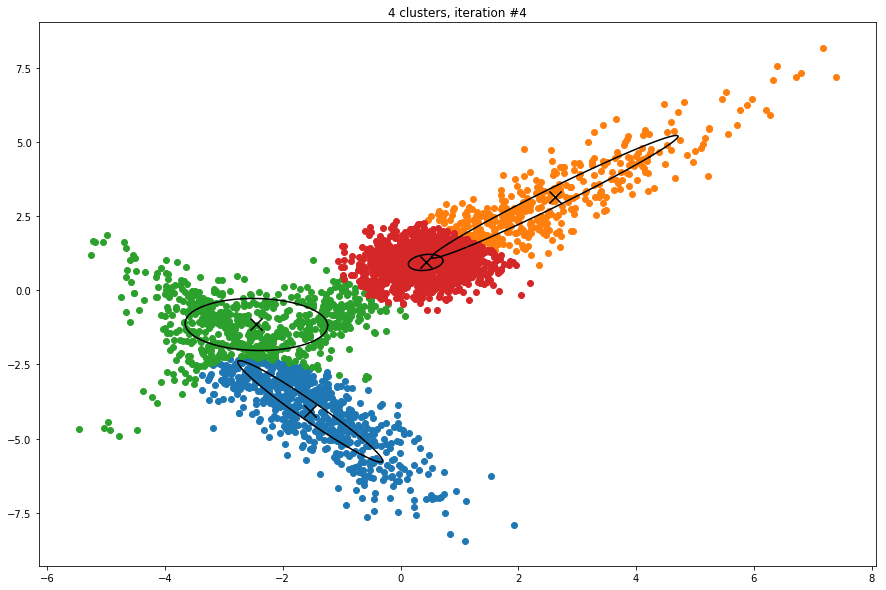

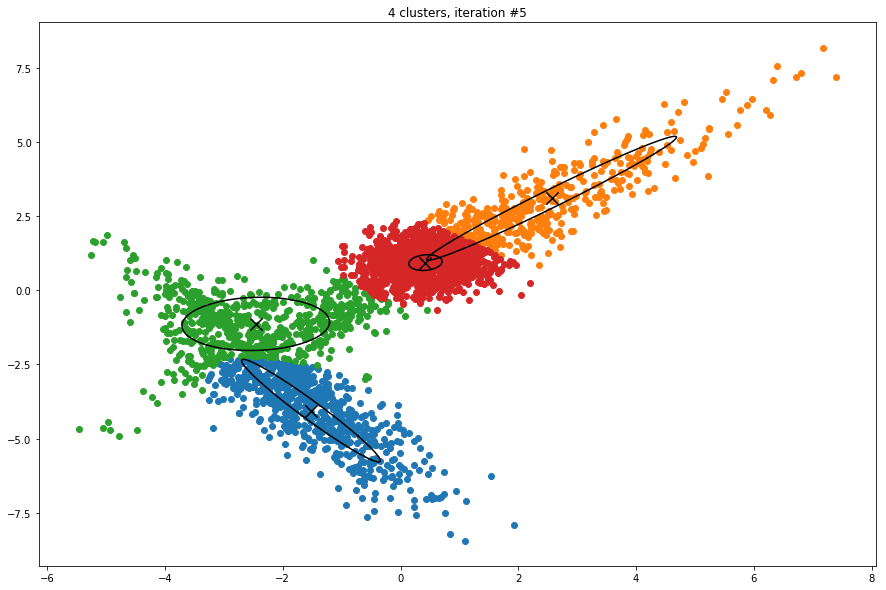

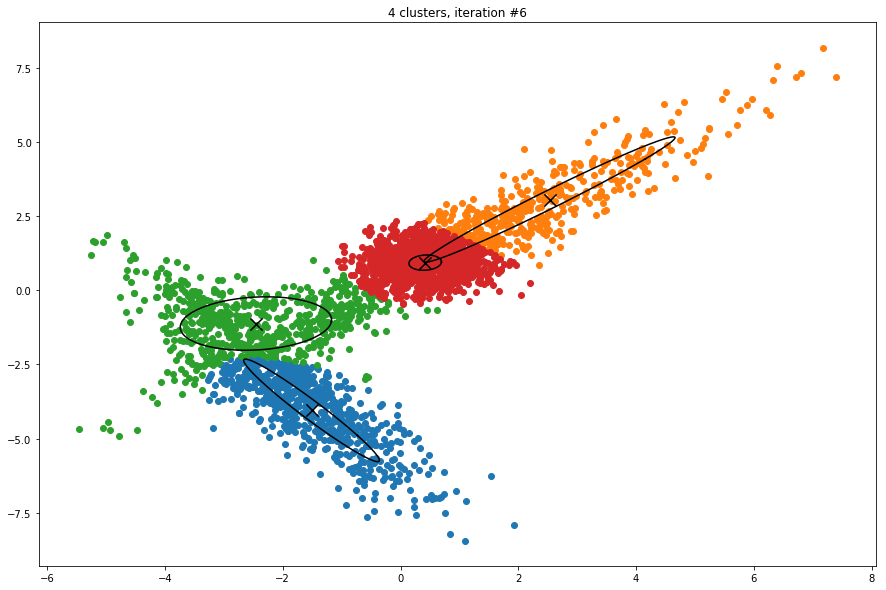

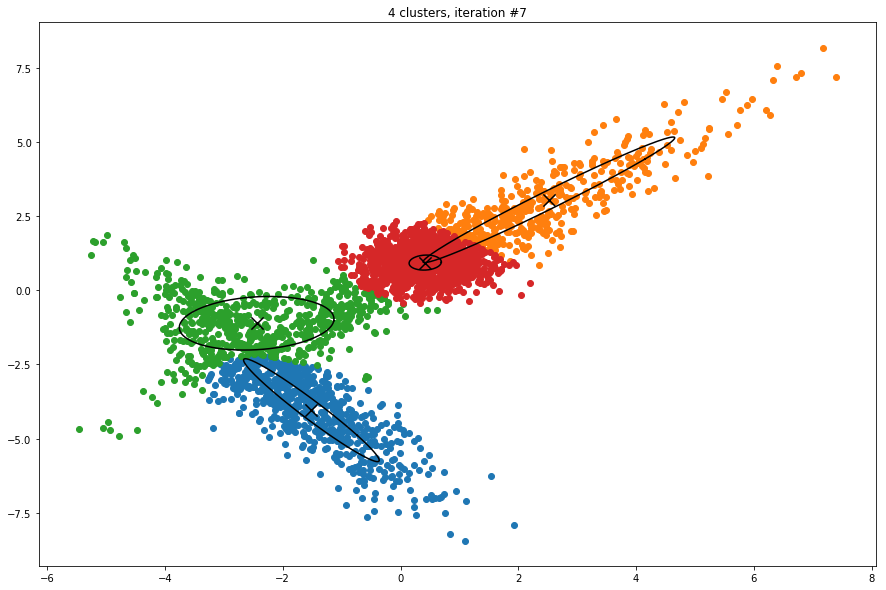

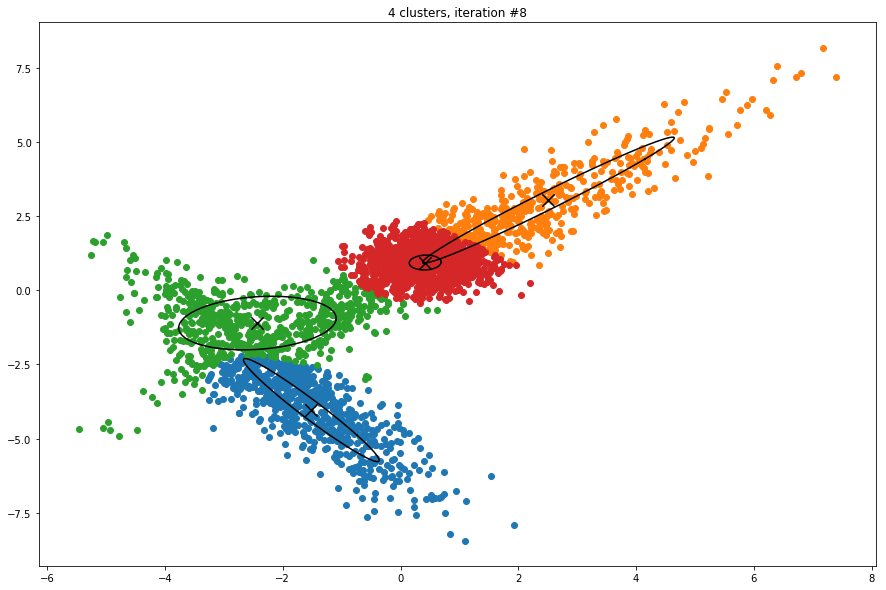

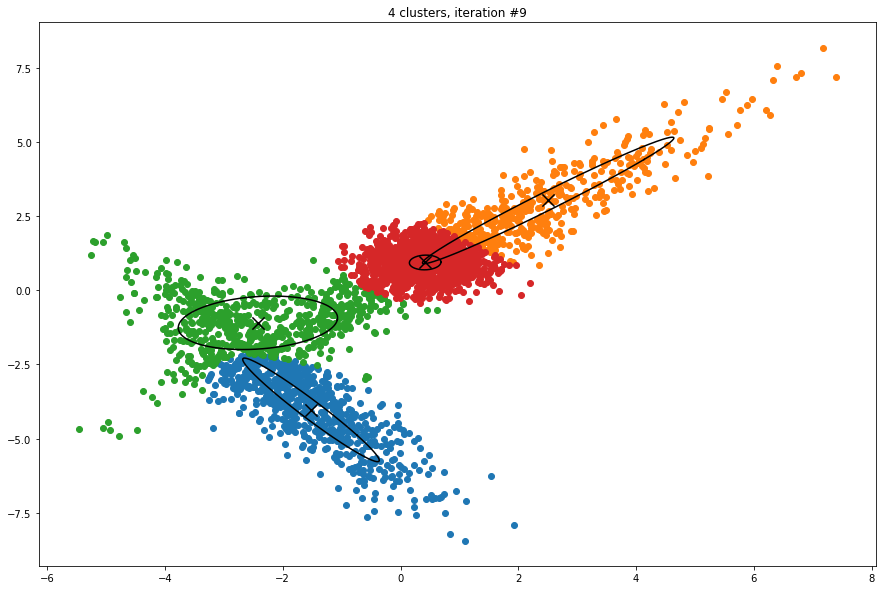

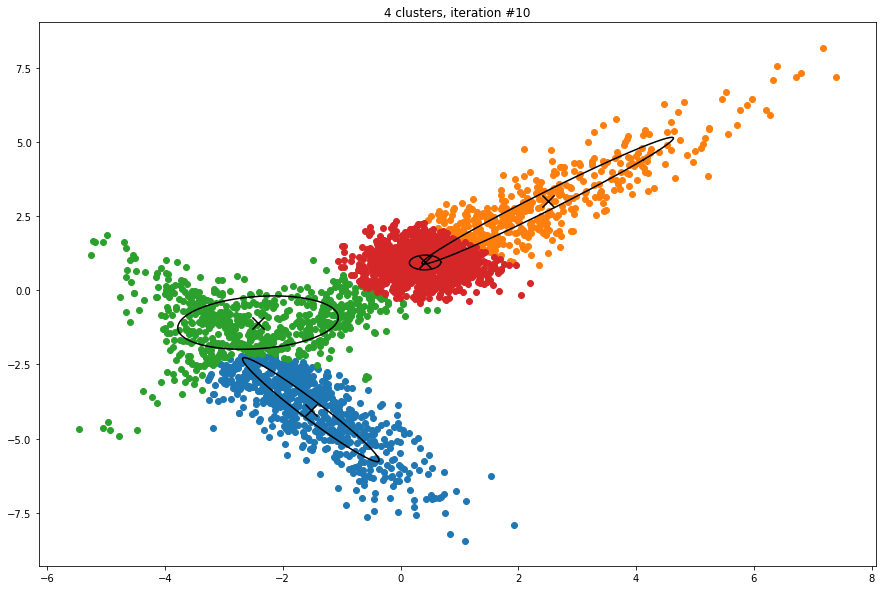

In [19]:
model = ExpectationMaximization(num_clusters=4)
model.fit(X, callback=visualize_clusters, num_iterations=10)

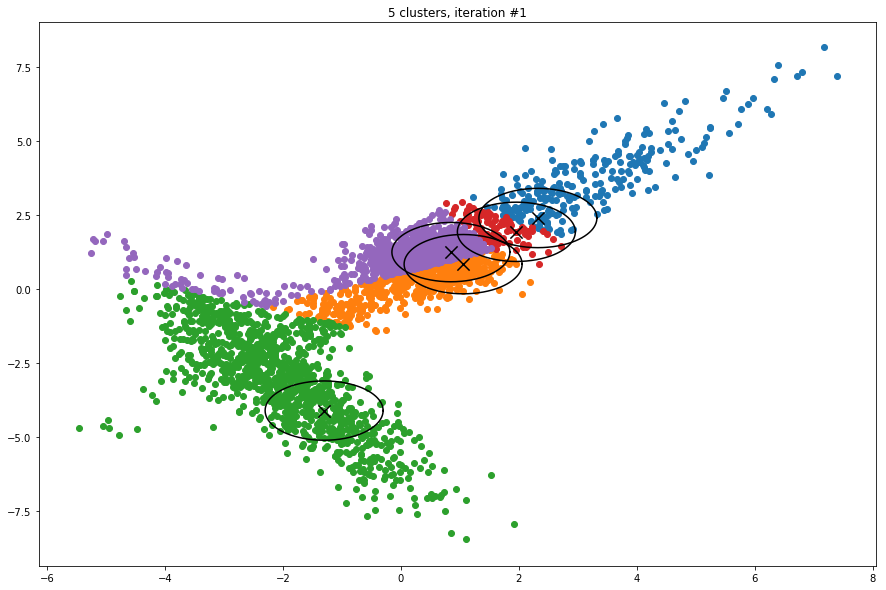

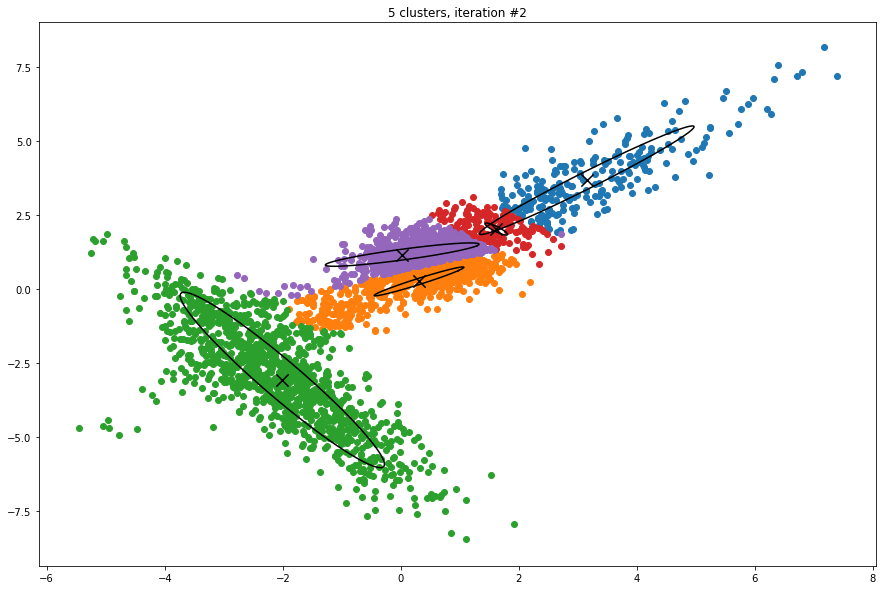

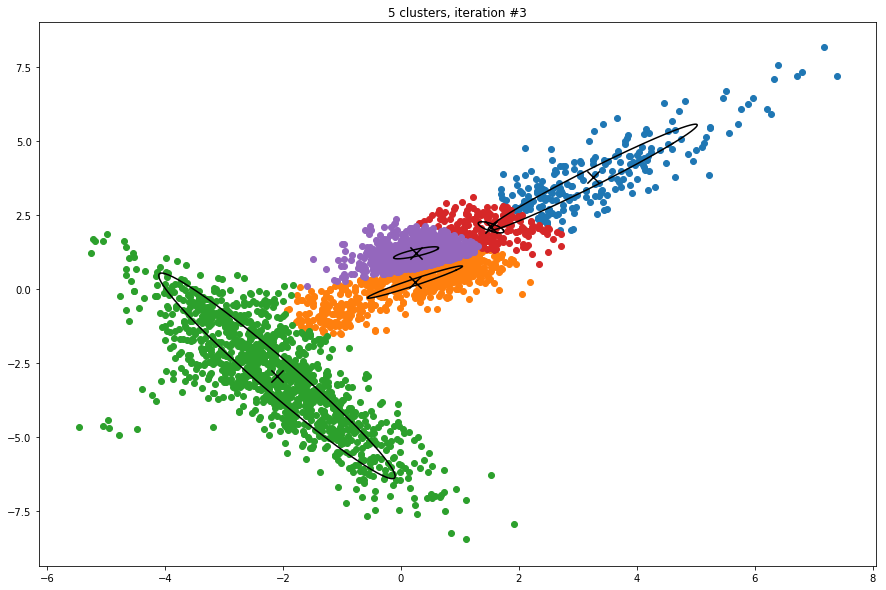

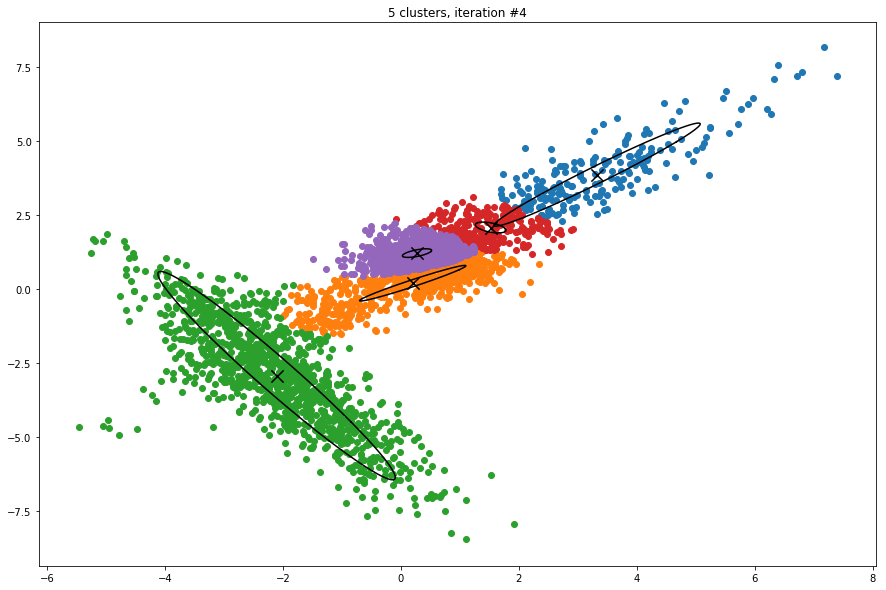

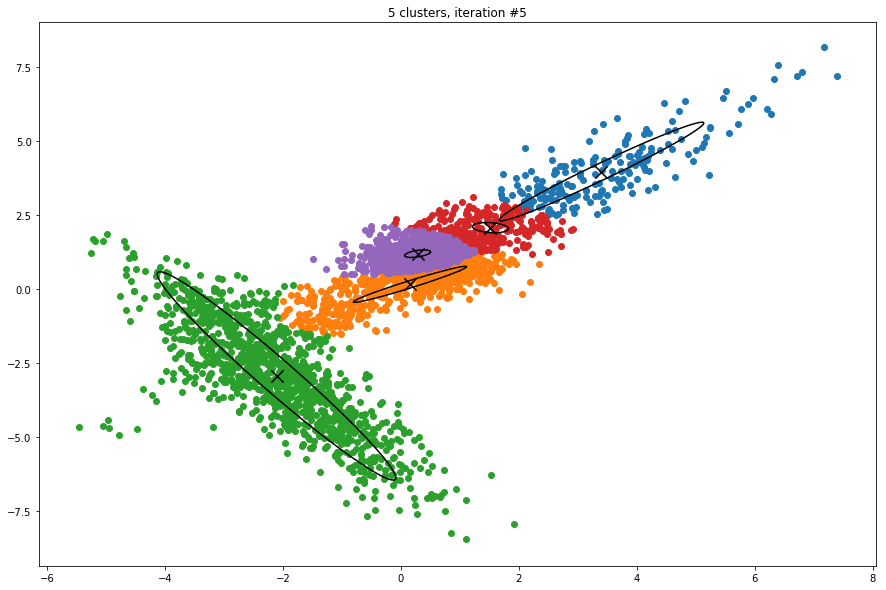

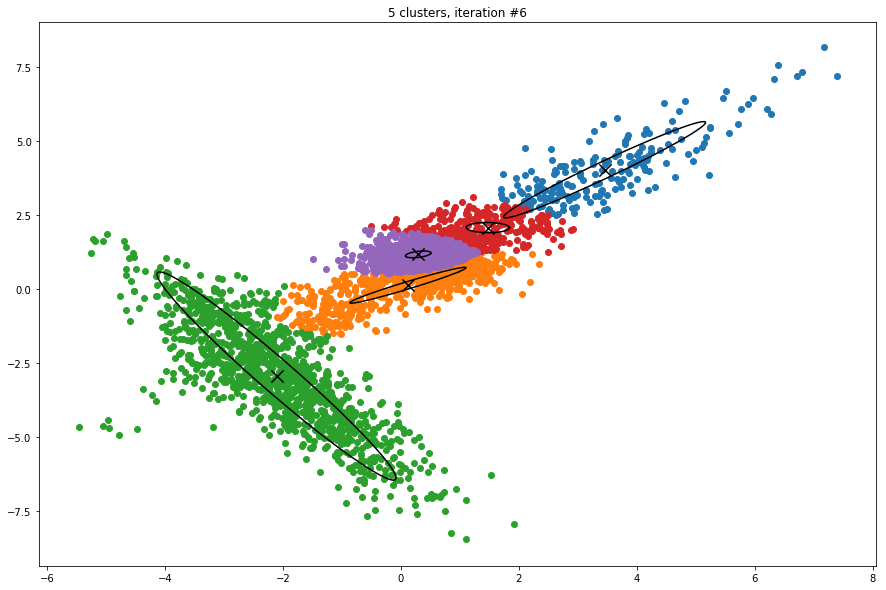

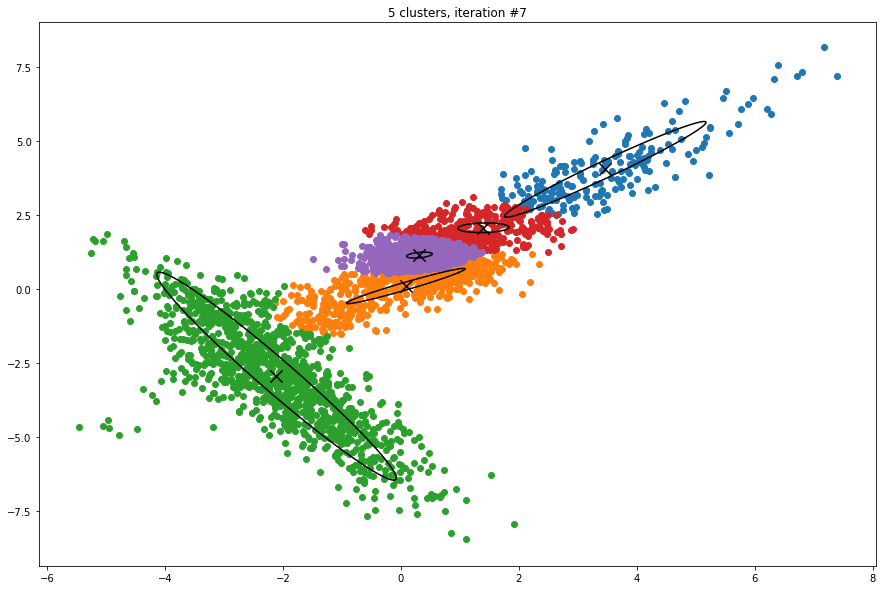

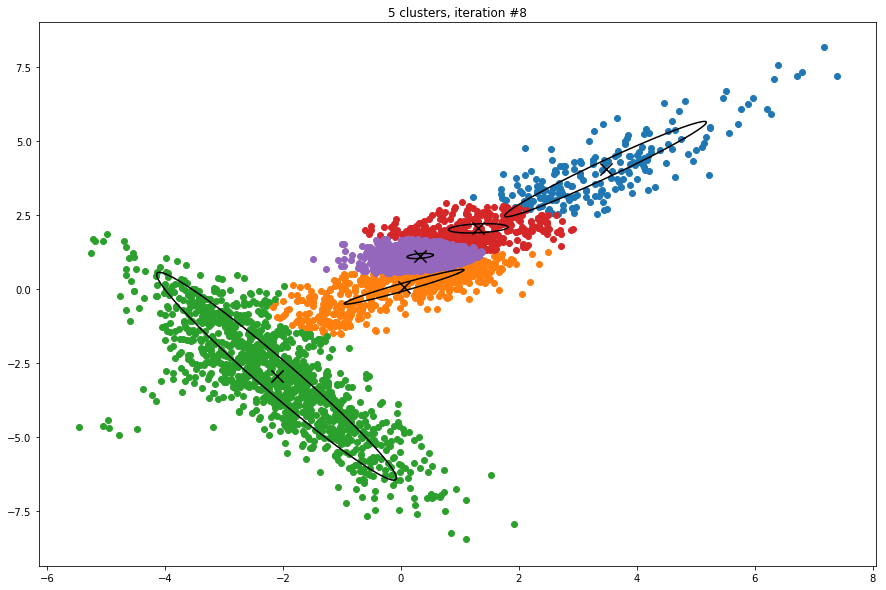

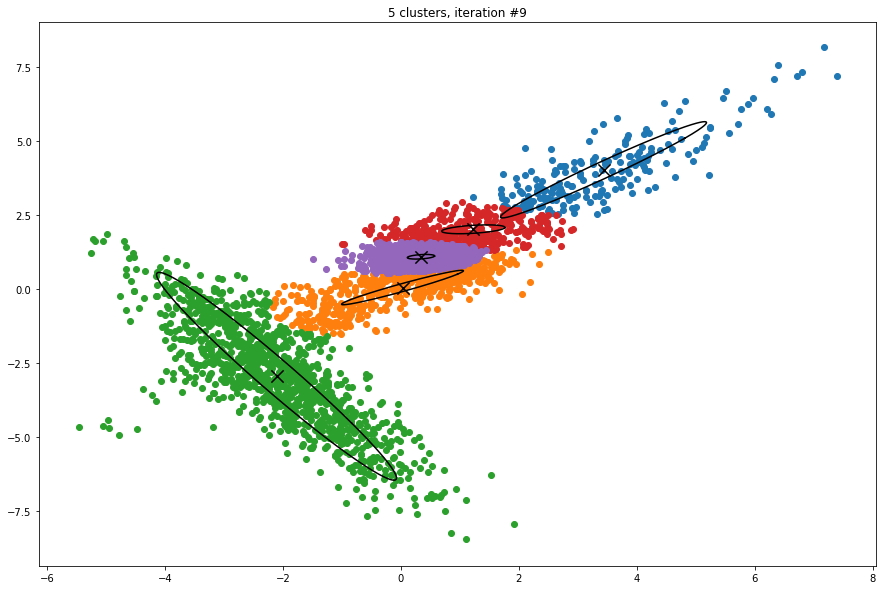

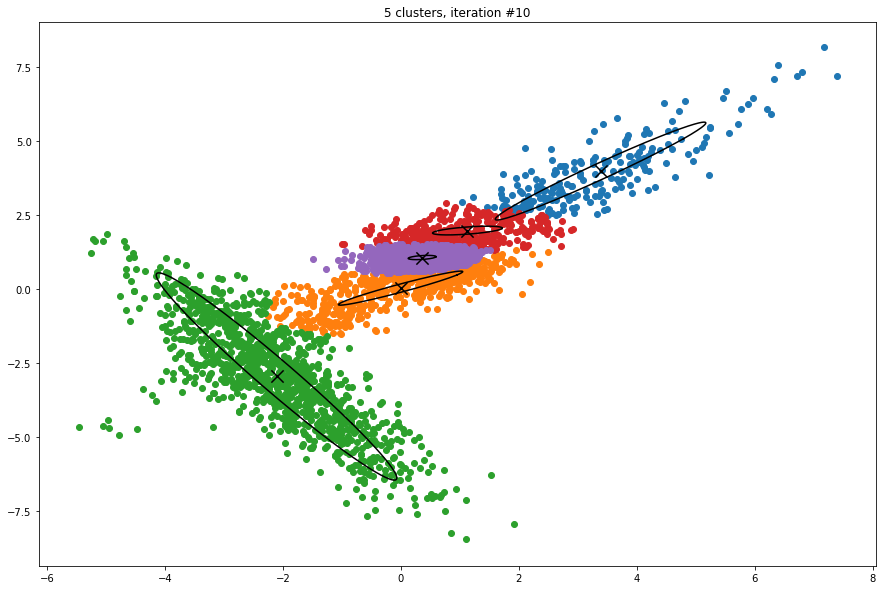

In [20]:
model = ExpectationMaximization(num_clusters=5)
model.fit(X, callback=visualize_clusters, num_iterations=10)

#### Visualisierung 2: Nach jeder Iteration den Plot aktualisieren

In [18]:
def visualize_clusters_redraw(*args):
    plt.clf()
    visualize_clusters(*args)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1)

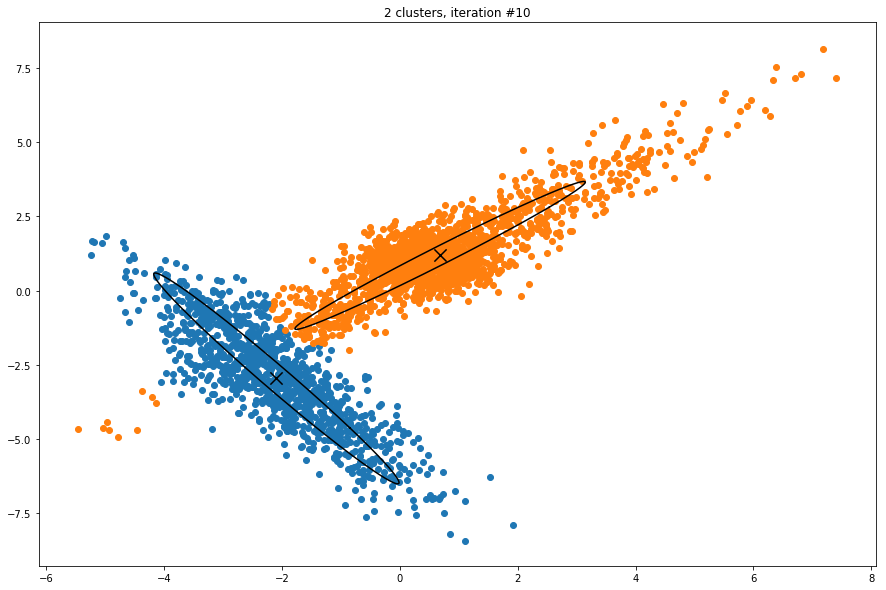

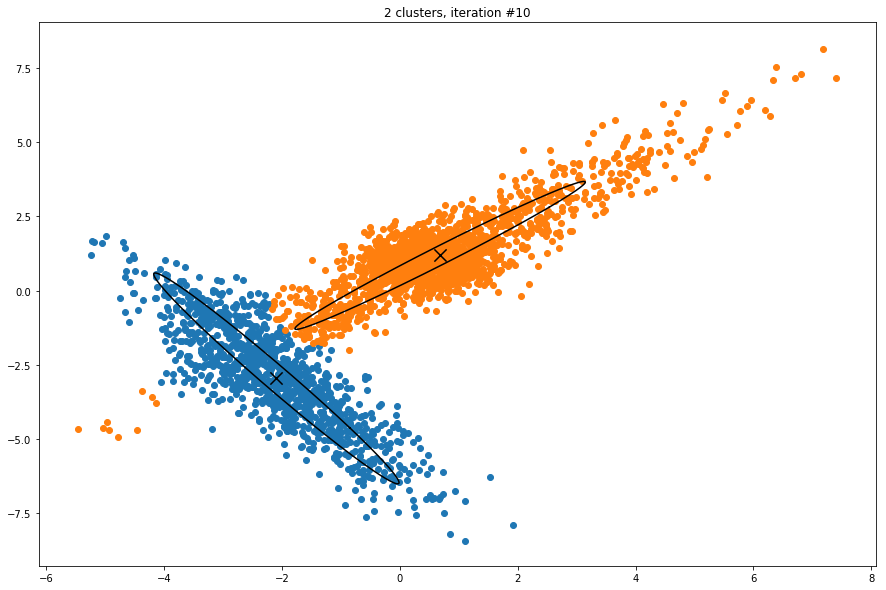

In [19]:
model = ExpectationMaximization(num_clusters=2, random_state=10)
model.fit(X, callback=visualize_clusters_redraw, num_iterations=10)

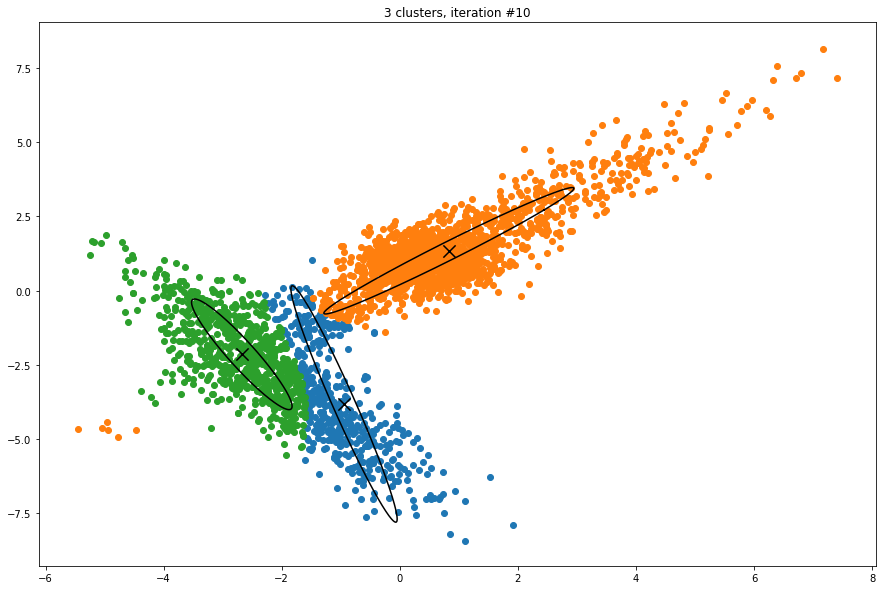

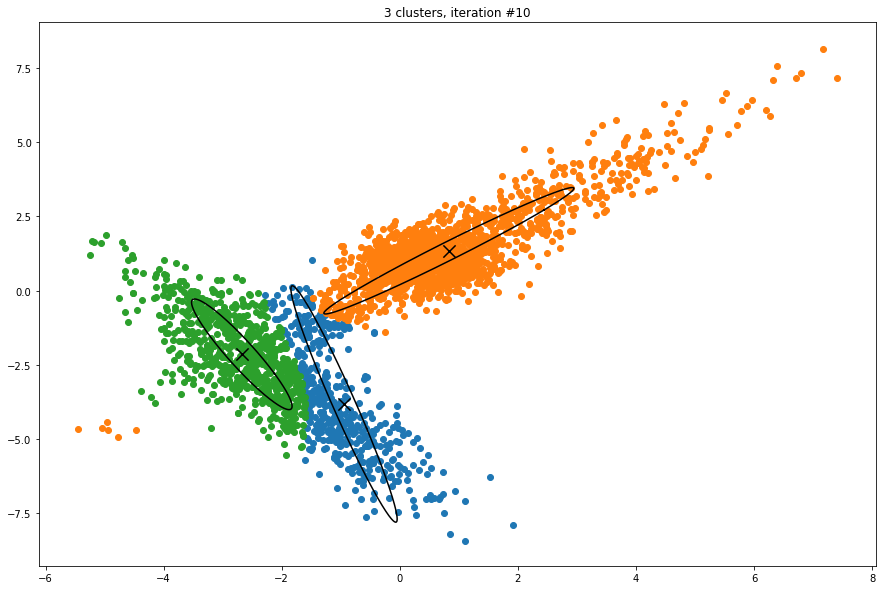

In [22]:
model = ExpectationMaximization(num_clusters=3, random_state=10)
model.fit(X, callback=visualize_clusters_redraw, num_iterations=10)

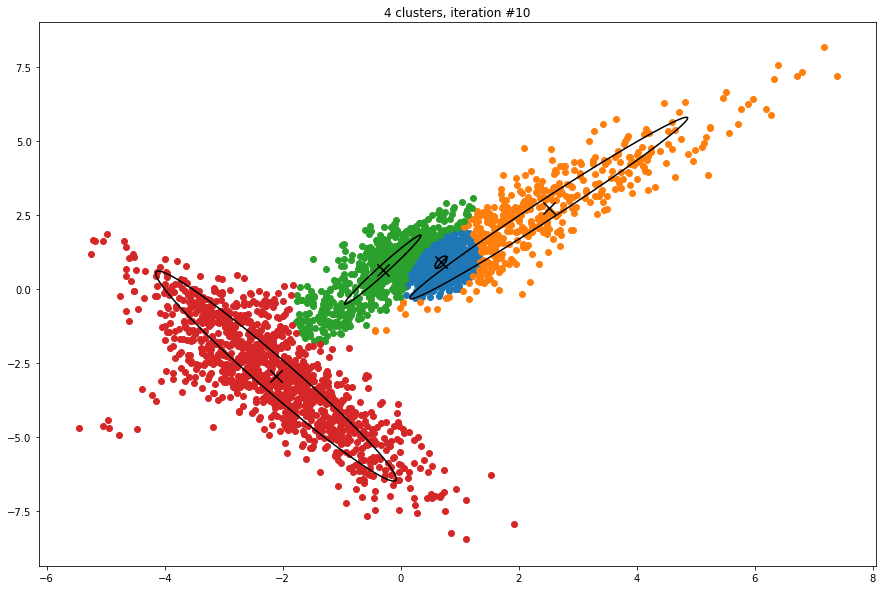

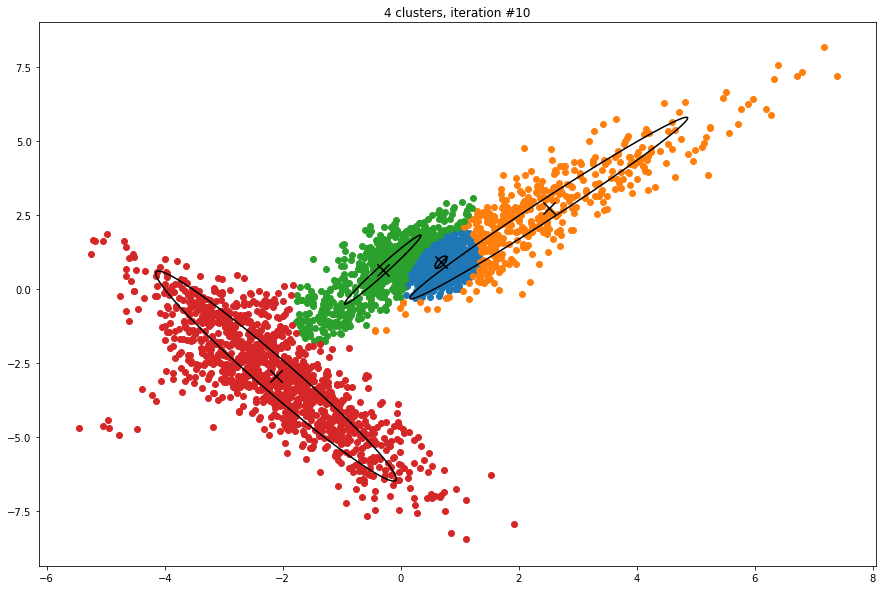

In [20]:
model = ExpectationMaximization(num_clusters=4, random_state=10)
model.fit(X, callback=visualize_clusters_redraw, num_iterations=10)

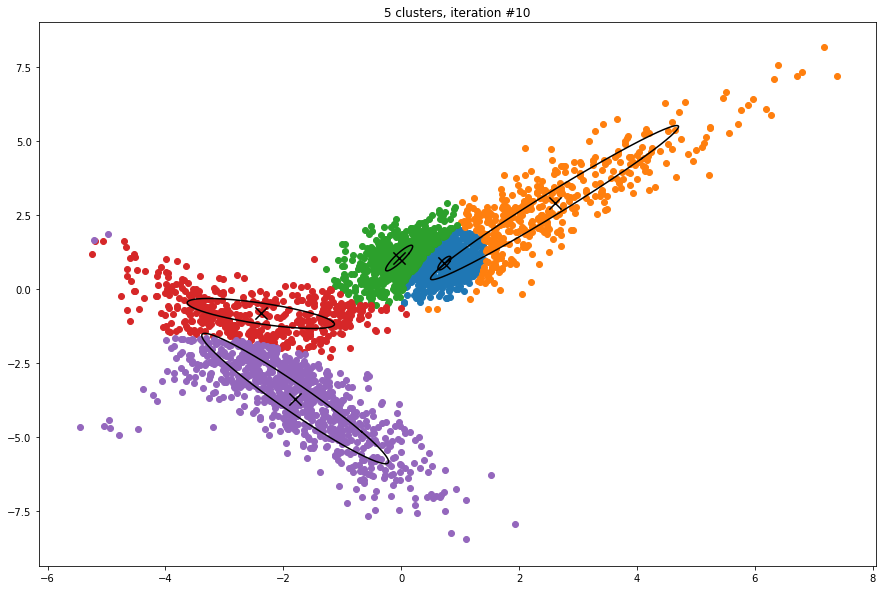

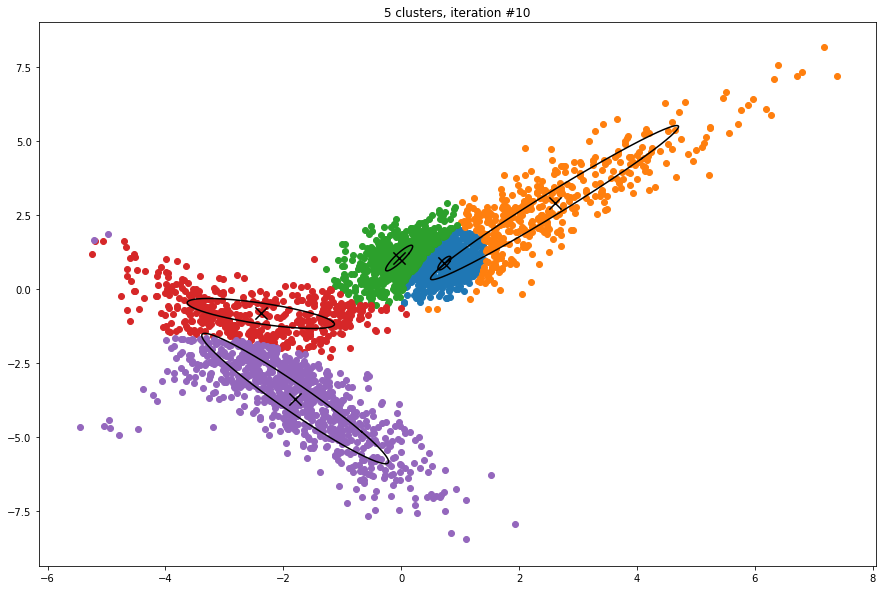

In [23]:
model = ExpectationMaximization(num_clusters=5, random_state=10)
model.fit(X, callback=visualize_clusters_redraw, num_iterations=10)

### Clustergüten evaluieren

In [25]:
max_num_clusters = 15
num_repetitions = 1

In [27]:
num_clusters = range(2, max_num_clusters + 1)
results = []

for i in num_clusters:
    goodnesses = []
    
    for _ in range(10):
        model = ExpectationMaximization(num_clusters=i)
        model.fit(X, num_iterations=50)
        goodnesses.append(model.evaluate())
    
    goodness = np.mean(goodnesses)
    print i, goodness
    results.append(goodness)

2 3.81414640542
3 3.25425416271
4 2.39162303565
5 1.75952297183
6 1.45251453057
7 1.26581965146
8 0.983256833768
9 0.947992771822
10 0.819337667388
11 0.71066120423
12 0.6365861347
13 0.696111930606
14 0.596483061416
15 0.59084289758


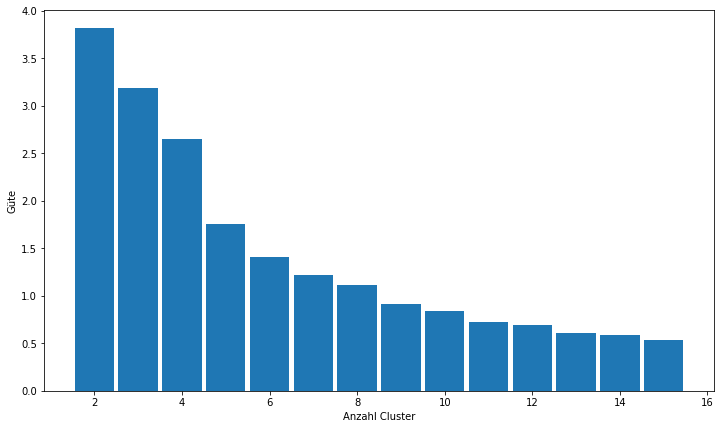

In [28]:
plt.figure(figsize=(12, 7))
plt.bar(num_clusters, results, width=0.9)
plt.xlabel("Anzahl Cluster")
plt.ylabel(u"Güte")

### K-Means

In [29]:
class KMeans(ExpectationMaximization):
    def _distance(self, X, mu, _):
        return norm(X - mu, axis=1)

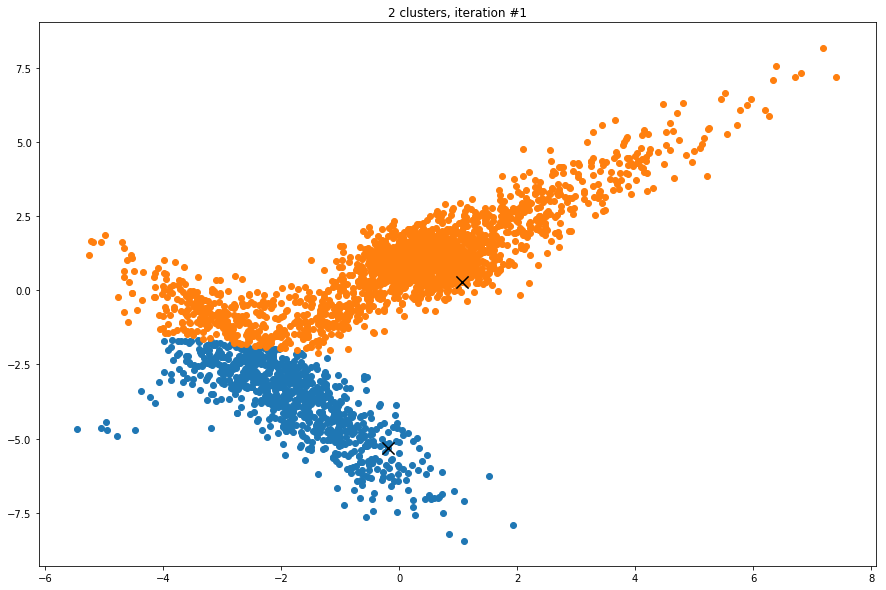

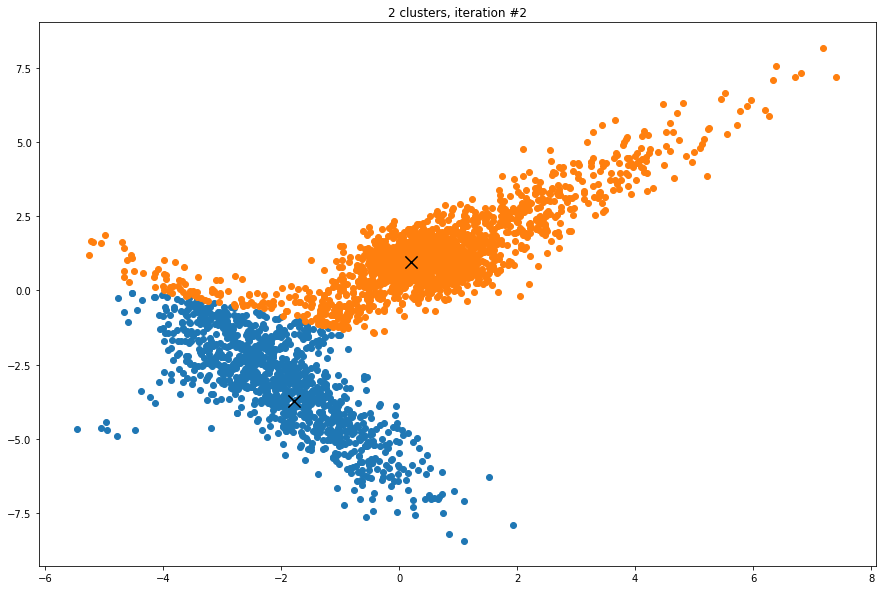

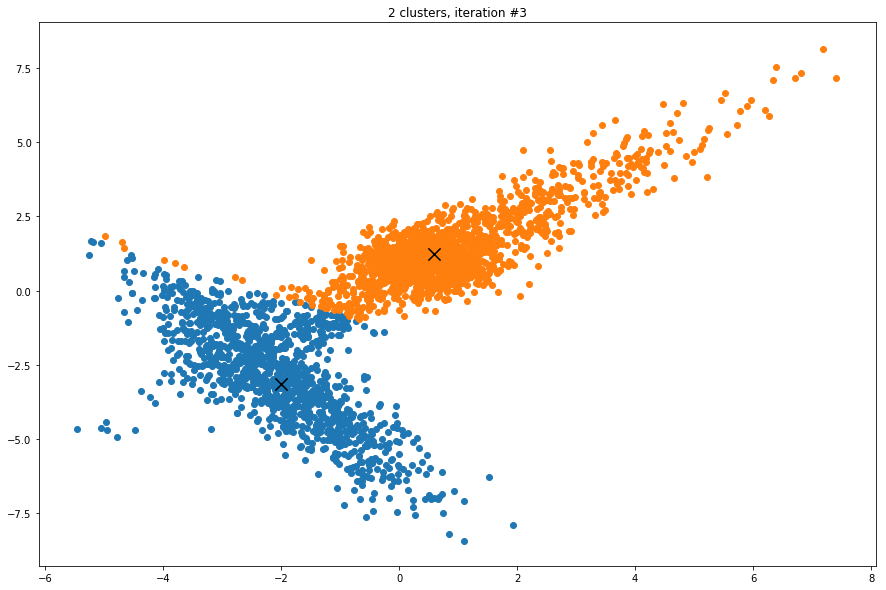

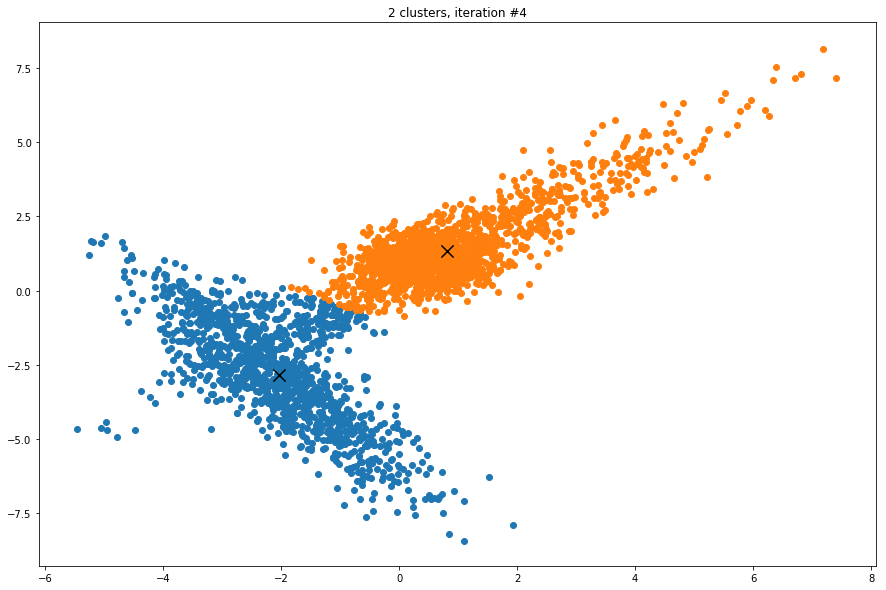

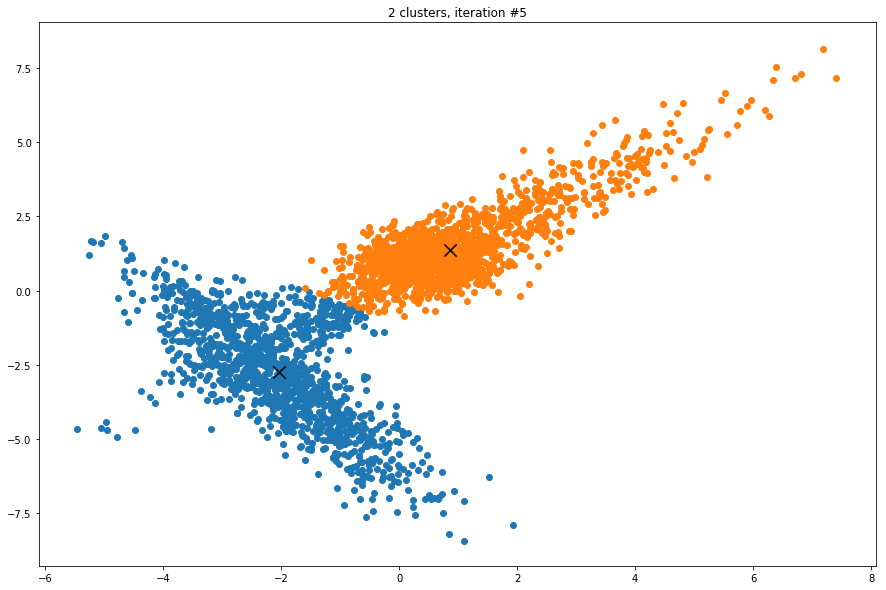

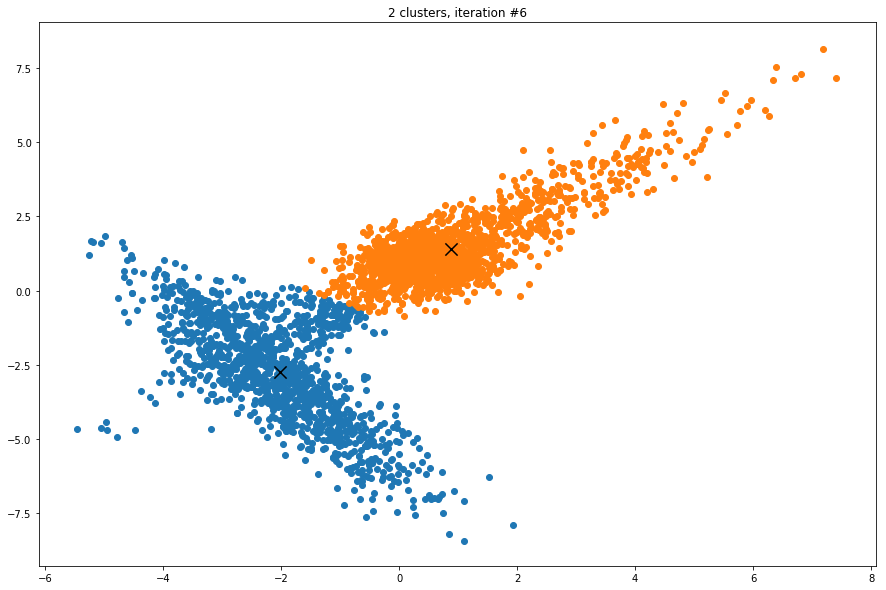

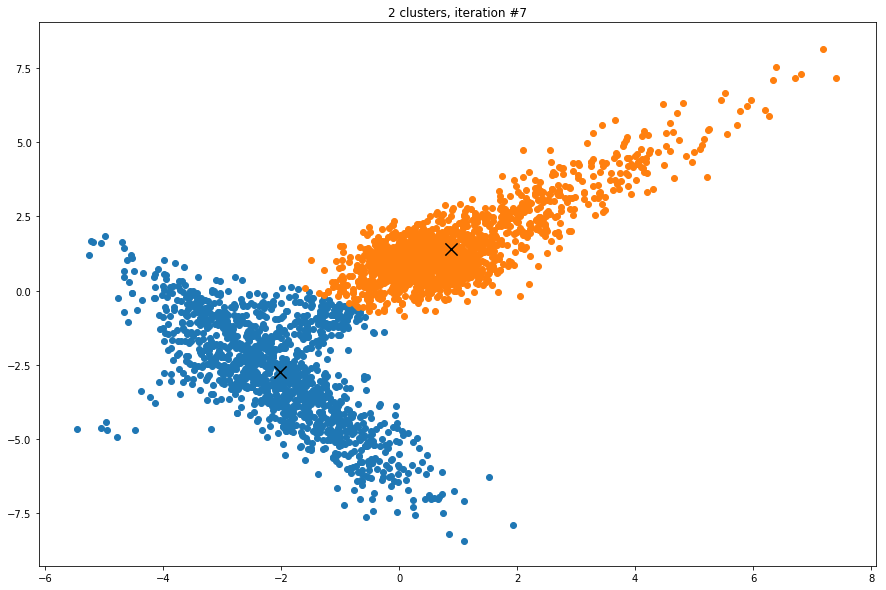

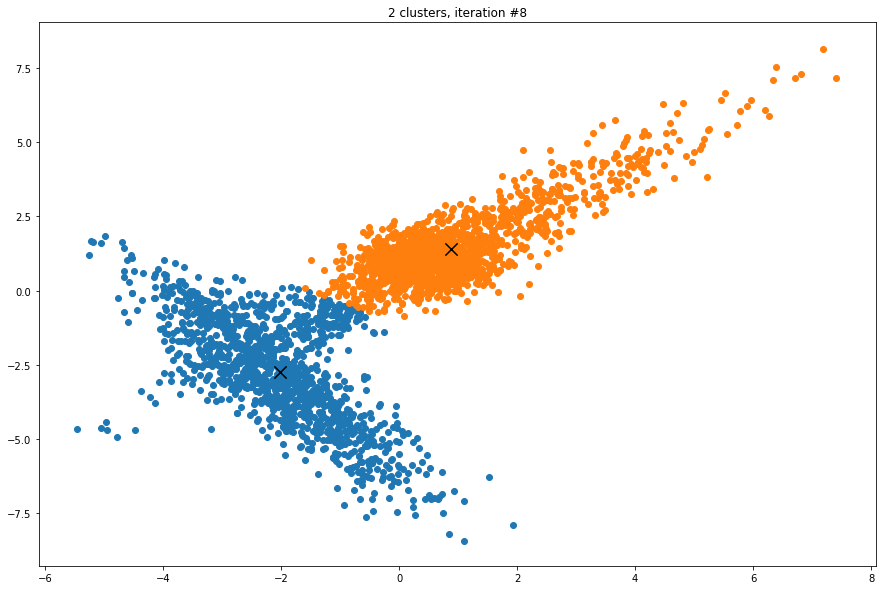

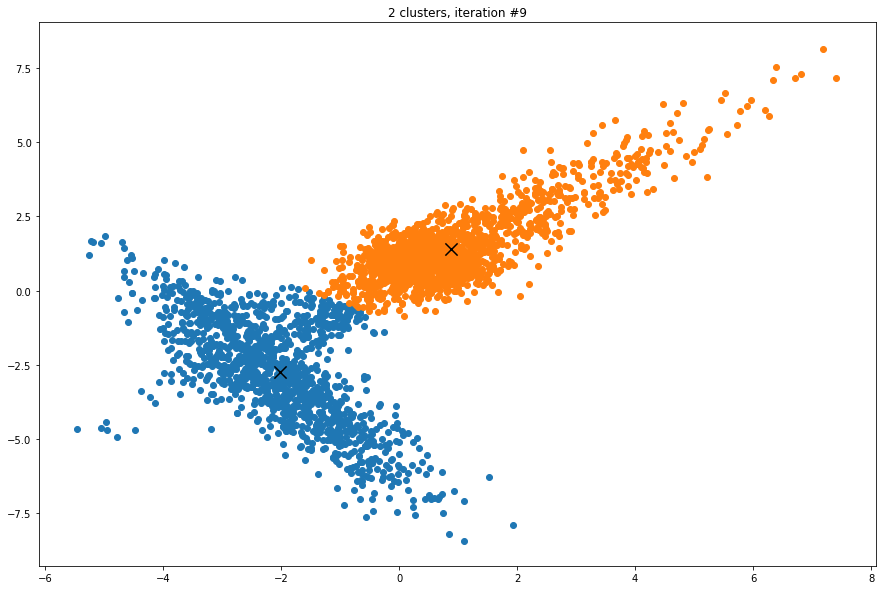

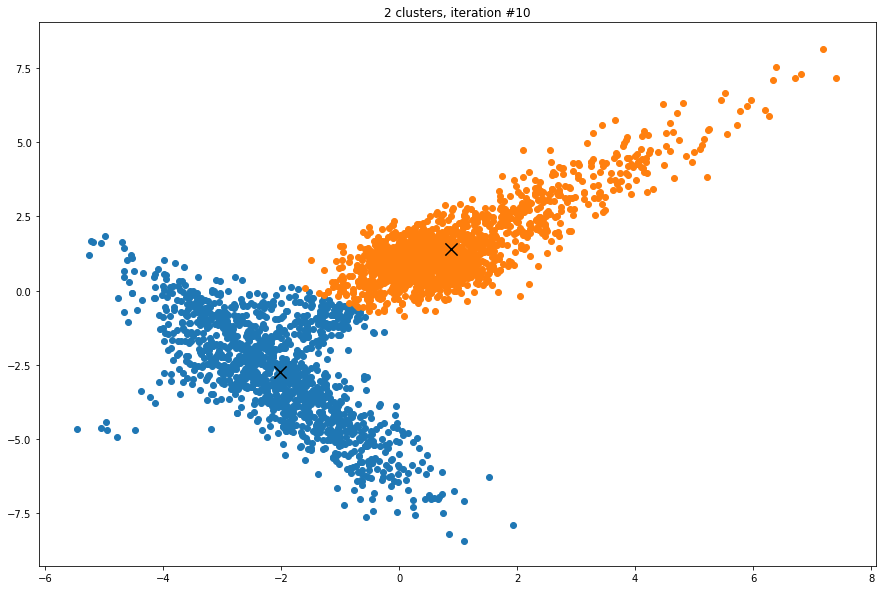

In [24]:
model = KMeans(num_clusters=2)
model.fit(X, callback=visualize_clusters, num_iterations=10)

## Aufgabe 2: Bildkompression

Interessante Wikipediaartikel dazu:
- [Color quantization](https://en.wikipedia.org/wiki/Color_quantization)
- [Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation#Compression-based_methods)

Wir sind hier aber natürlich mehr an der Clustering-Technik, als an der Bildkompression interessiert. Die Aufgabe dient eher dazu eine gute Visualisierung zu finden.

In [31]:
import matplotlib.image as mpimg

In [32]:
path = '/Users/florian/Desktop/photo2_smaller.jpg'

In [33]:
def show_img(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.show()

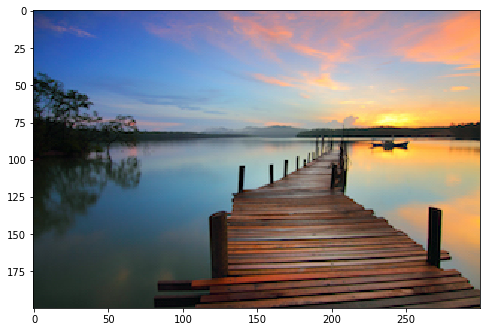

In [34]:
img = mpimg.imread(path)
show_img(img)

In [35]:
def compress_image(ClusterFactory, img, num_colors):
    rows, cols, channels = img.shape
    img = img.reshape(rows * cols, channels)
    
    model = ClusterFactory(num_clusters=num_colors)
    model.fit(img)
    
    clusters = np.asarray(model.means, dtype=np.uint8) 
    labels = model.predict(img)
    
    labels = labels.reshape(rows, cols)
    img_compressed = clusters[labels]
    
    return img_compressed

Aus Komprimierungsgründen (es werden $\log_2(n)$ Bits benötigt) macht es nur Sinn 2er-Potenzen zu betrachten.

In [49]:
num_colors = [1 << i for i in range(1, 11)]
num_colors

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

2


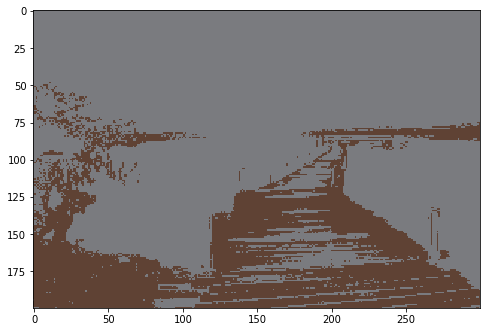

4


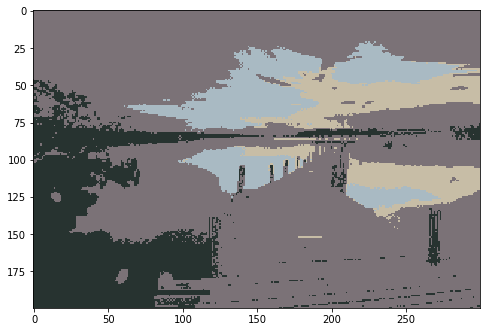

8


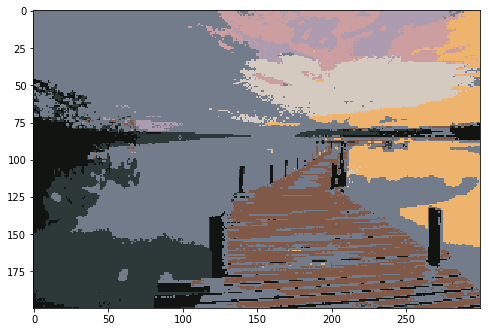

16


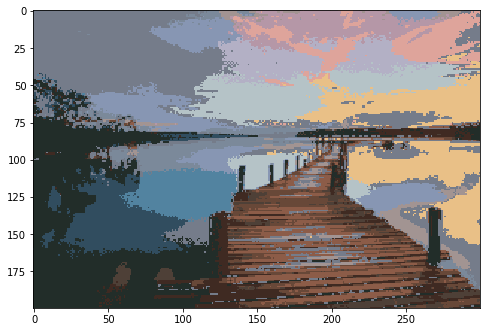

32


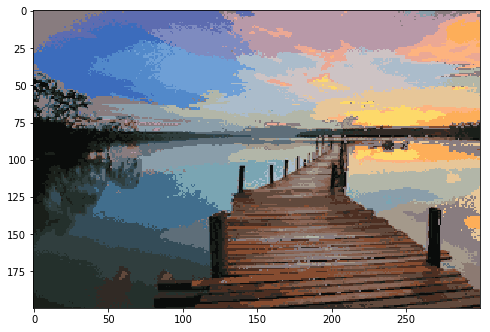

64


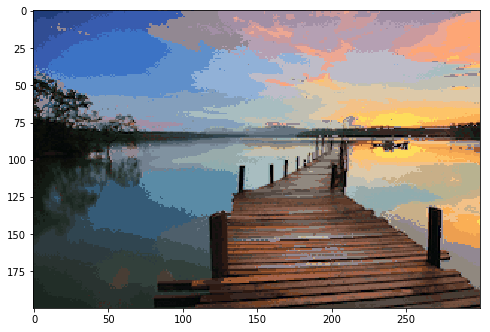

128


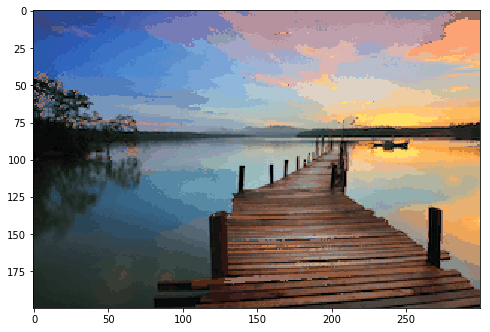

256


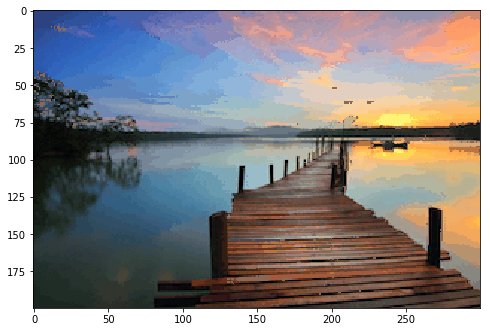

512


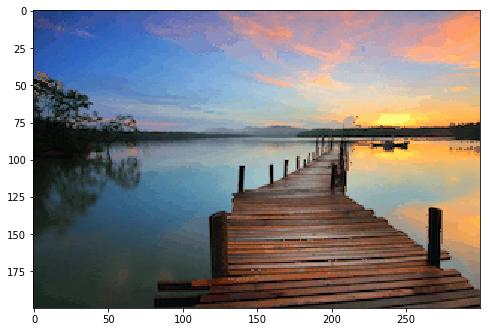

1024


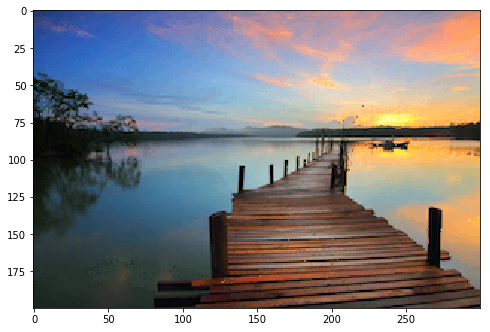

In [50]:
for num_colors in num_colors:
    print num_colors
    show_img(compress_image(ExpectationMaximization, img, num_colors))

### Vergleich mit K-Means

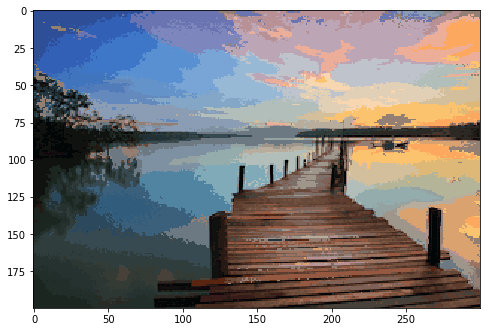

In [38]:
show_img(compress_image(ExpectationMaximization, img, 64))

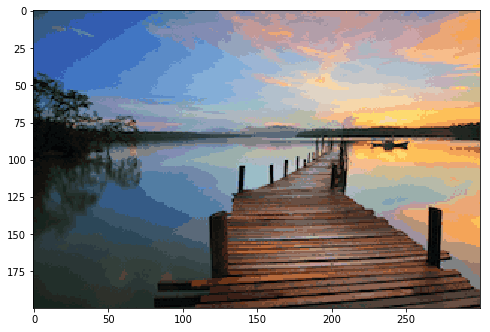

In [39]:
show_img(compress_image(KMeans, img, 64))

### Vergleich mit sklearn

In [40]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [41]:
def compress_image_sklearn(ClusterFactory, img, num_colors):
    rows, cols, channels = img.shape
    img = img.reshape(rows * cols, channels)
    
    model = ClusterFactory(num_colors)
    model.fit(img)
    
    if hasattr(model, "means_"):
        clusters = np.asarray(model.means_, dtype=np.uint8) 
    else:
        clusters = np.asarray(model.cluster_centers_, dtype=np.uint8) 
        
    labels = model.predict(img).reshape(rows, cols)
    img_compressed = clusters[labels]
    
    return img_compressed

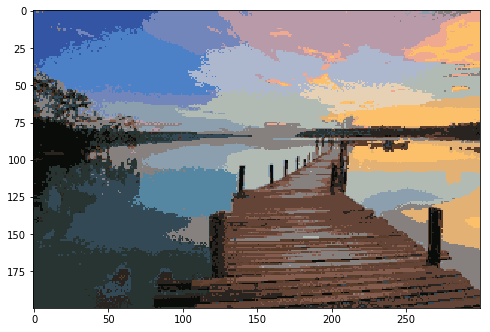

In [42]:
show_img(compress_image_sklearn(GaussianMixture, img, 20))

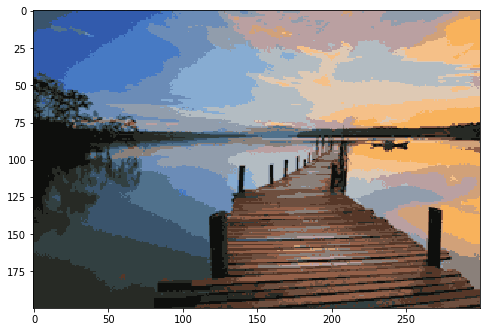

In [43]:
show_img(compress_image_sklearn(KMeans, img, 20))